#기본 경로 & 라이브러리 설치 / Google Drive 마운트

In [ ]:
# =======================================
# 0-1) Google Drive Mount
# =======================================
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# =======================================
# 0-2) 필수 라이브러리 설치
# =======================================
# tqdm 버전 충돌 방지: 4.67 이상 설치
!pip install -q "ultralytics==8.3.20" "pycocotools==2.0.8" "tqdm>=4.67,<5" "rich==13.7.1"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.7/240.7 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 7.2 MB/s eta 0:00:00


In [ ]:
# 0-3) 버전 확인
import sys, torch, platform, importlib.metadata
import ultralytics
print("Python     :", sys.version.split()[0])
print("Torch      :", torch.__version__)
print("Ultralytics:", ultralytics.__version__)
print("tqdm       :", importlib.metadata.version("tqdm"))
print("pycocotools:", importlib.metadata.version("pycocotools"))
print("rich       :", importlib.metadata.version("rich"))

Python     : 3.12.11
Torch      : 2.8.0+cu126
Ultralytics: 8.3.20
tqdm       : 4.67.1
pycocotools: 2.0.8
rich       : 13.7.1


In [ ]:
# 0-4) 경로 설정 & 작업 디렉토리 생성
from pathlib import Path
import json, time, math
from datetime import datetime

# === 사용자 데이터 루트 (필요 시 여기만 바꾸면 됨) ===
BASE = "/content/drive/MyDrive/Codeit_AI_4th_Drug_image_CV_project/data"

TRAIN_IMAGES_DIR = f"{BASE}/train_images"
TEST_IMAGES_DIR  = f"{BASE}/test_images"
TRAIN_ANN_ROOT   = f"{BASE}/train_annotations"   # 재귀 탐색 루트

# === 작업 산출물 디렉토리 ===
WORKDIR          = "/content/ev_pill_yolo"
YOLO_DATASET_DIR = f"{WORKDIR}/_yolo_dataset"
SPLIT_LIST_DIR   = f"{WORKDIR}/_splits"
MAP_DIR          = f"{WORKDIR}/_maps"
SUBMIT_DIR       = f"{WORKDIR}/_submit"
VAL_COCO_DIR     = f"{WORKDIR}/_val_coco_pred"

for d in [WORKDIR, YOLO_DATASET_DIR, SPLIT_LIST_DIR, MAP_DIR, SUBMIT_DIR, VAL_COCO_DIR]:
    Path(d).mkdir(parents=True, exist_ok=True)

def exists(p):
    return "✅" if Path(p).exists() else "❌"

print("\n=== Path Summary ===")
print("BASE                 :", BASE)
print("TRAIN_IMAGES_DIR     :", TRAIN_IMAGES_DIR, exists(TRAIN_IMAGES_DIR))
print("TEST_IMAGES_DIR      :", TEST_IMAGES_DIR,  exists(TEST_IMAGES_DIR))
print("TRAIN_ANN_ROOT       :", TRAIN_ANN_ROOT,  exists(TRAIN_ANN_ROOT))
print("WORKDIR              :", WORKDIR)

# ✅ tqdm 안전 임포트 (Jupyter/Colab 권장)
try:
    from tqdm.auto import tqdm  # 예쁜 진행바
except Exception:
    import tqdm as _tqdm
    tqdm = _tqdm.tqdm        # 모듈.tqdm을 함수로 바인딩


=== Path Summary ===
BASE                 : /content/drive/MyDrive/Codeit_AI_4th_Drug_image_CV_project/data
TRAIN_IMAGES_DIR     : /content/drive/MyDrive/Codeit_AI_4th_Drug_image_CV_project/data/train_images ✅
TEST_IMAGES_DIR      : /content/drive/MyDrive/Codeit_AI_4th_Drug_image_CV_project/data/test_images ✅
TRAIN_ANN_ROOT       : /content/drive/MyDrive/Codeit_AI_4th_Drug_image_CV_project/data/train_annotations ✅
WORKDIR              : /content/ev_pill_yolo


In [ ]:
# 0-5) COCO JSON 재귀 탐색 (진행률 표시) → 자동 선택
def is_coco_like(js: dict) -> bool:
    return (
        isinstance(js, dict)
        and isinstance(js.get("images"), list)
        and isinstance(js.get("annotations"), list)
        and isinstance(js.get("categories"), list)
    )

def score_candidate(p: Path, js: dict) -> float:
    """
    후보 점수화:
      - images 개수 ↑
      - annotations 개수 소폭 반영
      - 파일명에 'instances' 포함 시 가산점
      - 최근 수정일 가중치(최신 ↑)
    """
    n_img = len(js.get("images", []))
    n_ann = len(js.get("annotations", []))
    name_boost = 0.15 if "instances" in p.name.lower() else 0.0
    try:
        mtime = p.stat().st_mtime
        age_days = max(0.0, (time.time() - mtime) / (3600 * 24))
        recency = 1.0 / (1.0 + math.log1p(age_days))  # 0~1
    except Exception:
        recency = 0.5
    return (n_img * 1.0) + (n_ann * 0.0005) + (name_boost * 100) + (recency * 10)

def find_coco_jsons(root_dir: str):
    root = Path(root_dir)
    candidates = []
    if not root.exists():
        return candidates
    all_jsons = list(root.rglob("*.json"))
    for p in tqdm(all_jsons, desc="Scanning JSON files", unit="file"):
        try:
            if p.stat().st_size < 200:  # 너무 작은 JSON은 스킵
                continue
            with p.open("r") as f:
                js = json.load(f)
            if is_coco_like(js):
                candidates.append((p, js, score_candidate(p, js)))
        except Exception:
            # 읽기 실패/JSON 파싱 실패 등은 무시
            continue
    return candidates

print("\n🔎 재귀 탐색 시작:", TRAIN_ANN_ROOT)
cands = find_coco_jsons(TRAIN_ANN_ROOT)

if not cands:
    print("❌ COCO 스키마(JSON) 후보를 찾지 못했습니다. train_annotations 하위 구조를 확인하세요.")
    TRAIN_ANN_PATH = ""
    coco = None
else:
    # 스코어 기준 상위 후보 출력
    cands.sort(key=lambda x: x[2], reverse=True)
    topk = min(5, len(cands))
    print(f"\nCOCO 후보 {len(cands)}개 발견. 상위 {topk}개:")
    for i, (p, js, sc) in enumerate(cands[:topk], start=1):
        try:
            mtime = datetime.fromtimestamp(p.stat().st_mtime).strftime("%Y-%m-%d %H:%M:%S")
        except Exception:
            mtime = "unknown"
        print(f"[{i}] score={sc:.2f} | images={len(js['images'])} | anns={len(js['annotations'])} | path={p}")
        print(f"     modified: {mtime}")

    # 최상위 1개 자동 선택
    best_path, best_js, best_score = cands[0]
    TRAIN_ANN_PATH = str(best_path)
    coco = best_js

    print("\n✅ 선택된 주석 파일:", TRAIN_ANN_PATH)
    print("COCO keys (images/annotations/categories):", "✅" if is_coco_like(coco) else "❌")
    print("images:", len(coco["images"]), "| annotations:", len(coco["annotations"]), "| categories:", len(coco["categories"]))
    if coco["images"]:
        sample_img = coco["images"][0]
        for k in ["id", "width", "height", "file_name"]:
            print(f"images[].{k} present:", "✅" if k in sample_img else "❌")


🔎 재귀 탐색 시작: /content/drive/MyDrive/Codeit_AI_4th_Drug_image_CV_project/data/train_annotations


Scanning JSON files:   0%|          | 0/4527 [00:00<?, ?file/s]


COCO 후보 4527개 발견. 상위 5개:
[1] score=1506.27 | images=1489 | anns=27154 | path=/content/drive/MyDrive/Codeit_AI_4th_Drug_image_CV_project/data/train_annotations/_merged/annotations_train_merged.json
     modified: 2025-09-18 11:37:13
[2] score=4.46 | images=1 | anns=1 | path=/content/drive/MyDrive/Codeit_AI_4th_Drug_image_CV_project/data/train_annotations/K-001900-016548-018110-029451_json/K-001900/K-001900-016548-018110-029451_0_2_0_2_90_000_200.json
     modified: 2025-09-17 09:06:46
[3] score=4.46 | images=1 | anns=1 | path=/content/drive/MyDrive/Codeit_AI_4th_Drug_image_CV_project/data/train_annotations/K-001900-016548-018110-029451_json/K-001900/K-001900-016548-018110-029451_0_2_0_2_70_000_200.json
     modified: 2025-09-17 09:06:46
[4] score=4.46 | images=1 | anns=1 | path=/content/drive/MyDrive/Codeit_AI_4th_Drug_image_CV_project/data/train_annotations/K-001900-016548-018110-029451_json/K-001900/K-001900-016548-018110-029451_0_2_0_2_75_000_200.json
     modified: 2025-09-17 09:06

In [ ]:
# 0-6) GPU/환경 확인
print("\n=== Environment ===")
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    try:
        print("CUDA device  :", torch.cuda.get_device_name(0))
        print("CUDA mem (allocated/reserved, GB):",
              round(torch.cuda.memory_allocated()/1e9, 3), "/",
              round(torch.cuda.memory_reserved()/1e9, 3))
    except Exception:
        print("CUDA device  : (unavailable name)")
print("Platform     :", platform.platform())


=== Environment ===
CUDA available: True
CUDA device  : Tesla T4
CUDA mem (allocated/reserved, GB): 0.0 / 0.0
Platform     : Linux-6.6.97+-x86_64-with-glibc2.35


# 데이터셋 분석 및 시각화

In [ ]:
import json
from collections import Counter
import numpy as np
from pathlib import Path

# === 경로 지정 ===
ANN_PATH = TRAIN_ANN_PATH  # 앞 단계에서 자동 선택된 instances_train.json

with open(ANN_PATH, "r") as f:
    coco = json.load(f)

images = coco["images"]
annotations = coco["annotations"]
categories = coco["categories"]

print("총 이미지 수 :", len(images))
print("총 어노테이션 수 :", len(annotations))
print("총 클래스 수 :", len(categories))

# --- 이미지 크기 통계 ---
widths  = [im["width"] for im in images]
heights = [im["height"] for im in images]

print("\n이미지 크기 통계")
print("평균 (W,H):", (np.mean(widths), np.mean(heights)))
print("최소/최대 W:", min(widths), max(widths))
print("최소/최대 H:", min(heights), max(heights))

# --- 카테고리 분포 ---
cat_id2name = {c["id"]: c["name"] for c in categories}
cat_counts = Counter([ann["category_id"] for ann in annotations])

print("\n클래스별 어노테이션 개수 (상위 10)")
for cid, cnt in cat_counts.most_common(10):
    print(f"{cid:>5} ({cat_id2name.get(cid, 'NA')}): {cnt}")

# --- bbox 통계 ---
bboxes = np.array([ann["bbox"] for ann in annotations])  # [x,y,w,h]
areas = bboxes[:,2] * bboxes[:,3]

print("\n바운딩박스 크기 통계")
print("평균 (w,h):", (np.mean(bboxes[:,2]), np.mean(bboxes[:,3])))
print("최소 (w,h):", (np.min(bboxes[:,2]), np.min(bboxes[:,3])))
print("최대 (w,h):", (np.max(bboxes[:,2]), np.max(bboxes[:,3])))
print("평균 area :", np.mean(areas))
print("최소/최대 area:", np.min(areas), np.max(areas))

# --- 이미지당 객체 수 ---
imgid_counts = Counter([ann["image_id"] for ann in annotations])
objs_per_img = list(imgid_counts.values())

print("\n이미지당 객체 수 통계")
print("평균:", np.mean(objs_per_img))
print("최소:", np.min(objs_per_img))
print("최대:", np.max(objs_per_img))


총 이미지 수 : 1489
총 어노테이션 수 : 27154
총 클래스 수 : 73

이미지 크기 통계
평균 (W,H): (np.float64(976.0), np.float64(1280.0))
최소/최대 W: 976 976
최소/최대 H: 1280 1280

클래스별 어노테이션 개수 (상위 10)
   51 (기넥신에프정(은행엽엑스)(수출용)): 3084
   30 (일양하이트린정 2mg): 1440
    1 (보령부스파정 5mg): 1080
   16 (뮤테란캡슐 100mg): 1032
    5 (가바토파정 100mg): 858
    2 (동아가바펜틴정 800mg): 834
   39 (아토젯정 10/40mg): 678
   38 (리바로정 4mg): 666
   32 (리피토정 20mg): 654
   33 (크레스토정 20mg): 648

바운딩박스 크기 통계
평균 (w,h): (np.float64(259.26913161965086), np.float64(288.7078146866023))
최소 (w,h): (np.float64(1.0), np.float64(1.0))
최대 (w,h): (np.float64(529.0), np.float64(669.0))
평균 area : 78858.02592619872
최소/최대 area: 217.0 272435.0

이미지당 객체 수 통계
평균: 18.236400268636668
최소: 6
최대: 24


## 기본 로드 & 통계 준비

In [ ]:
import json, math, os
from collections import Counter, defaultdict
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

# === COCO 경로: 앞 단계에서 설정된 변수 사용 ===
ANN_PATH = TRAIN_ANN_PATH  # 예: "/content/ev_pill_yolo/train_clean.json" 또는 auto-found json

with open(ANN_PATH, "r") as f:
    coco = json.load(f)

images = coco["images"]
anns   = coco["annotations"]
cats   = coco["categories"]

img_by_id = {im["id"]: im for im in images}
cat_id2name = {c["id"]: c.get("name", str(c["id"])) for c in cats}

# ====== 통계용 배열 ======
Ws  = np.array([im["width"]  for im in images], dtype=float)
Hs  = np.array([im["height"] for im in images], dtype=float)
ARs_img = Ws / Hs  # 이미지 종횡비

bboxes = np.array([a["bbox"] for a in anns], dtype=float) if len(anns) else np.zeros((0,4))
bbox_w = bboxes[:,2] if len(bboxes) else np.array([])
bbox_h = bboxes[:,3] if len(bboxes) else np.array([])
bbox_area = (bbox_w * bbox_h) if len(bboxes) else np.array([])
bbox_ar = (bbox_w / np.maximum(bbox_h, 1e-6)) if len(bboxes) else np.array([])

# 이미지당 객체 수
counts_per_img = Counter([a["image_id"] for a in anns])
objs_per_img = np.array(list(counts_per_img.values())) if counts_per_img else np.array([0])

# 클래스 분포
counts_per_cat = Counter([a["category_id"] for a in anns])
cat_ids_sorted = [cid for cid, _ in counts_per_cat.most_common()]
cat_names_sorted = [cat_id2name.get(cid, str(cid)) for cid in cat_ids_sorted]
cat_counts_sorted = [counts_per_cat[cid] for cid in cat_ids_sorted]

print("총 이미지:", len(images), "| 총 어노테이션:", len(anns), "| 총 클래스:", len(cats))


총 이미지: 1489 | 총 어노테이션: 27154 | 총 클래스: 73


## 이미지 크기/종횡비 분포

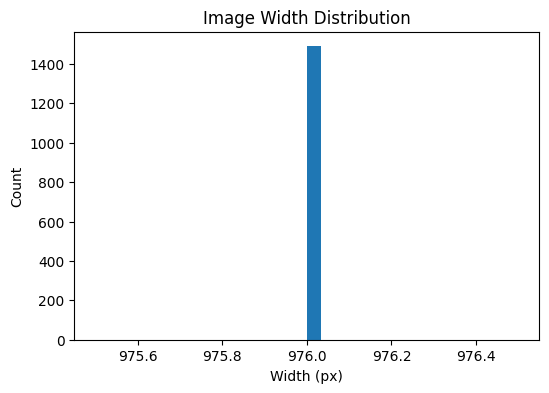

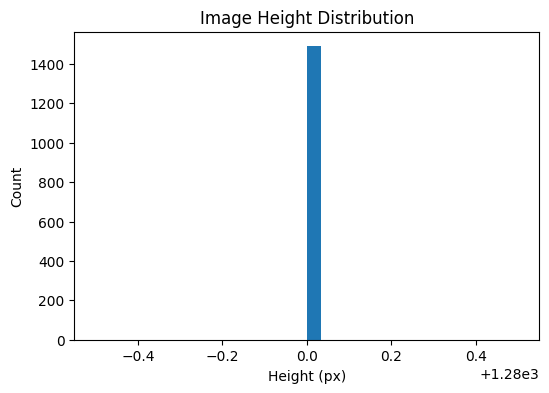

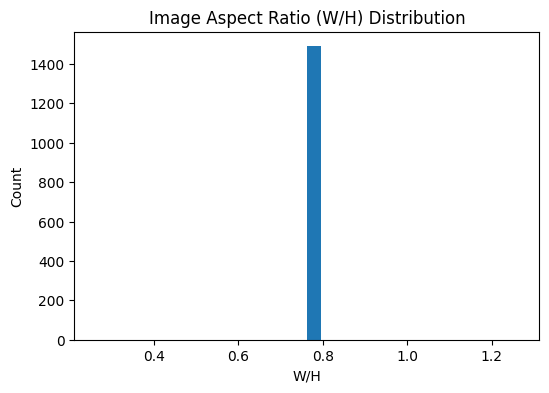

In [ ]:
# 이미지 폭 분포
plt.figure(figsize=(6,4))
plt.hist(Ws, bins=30)
plt.title("Image Width Distribution")
plt.xlabel("Width (px)")
plt.ylabel("Count")
plt.show()

# 이미지 높이 분포
plt.figure(figsize=(6,4))
plt.hist(Hs, bins=30)
plt.title("Image Height Distribution")
plt.xlabel("Height (px)")
plt.ylabel("Count")
plt.show()

# 이미지 종횡비 분포
plt.figure(figsize=(6,4))
plt.hist(ARs_img, bins=30)
plt.title("Image Aspect Ratio (W/H) Distribution")
plt.xlabel("W/H")
plt.ylabel("Count")
plt.show()


## 클래스 분포 (전체 / Top-N)

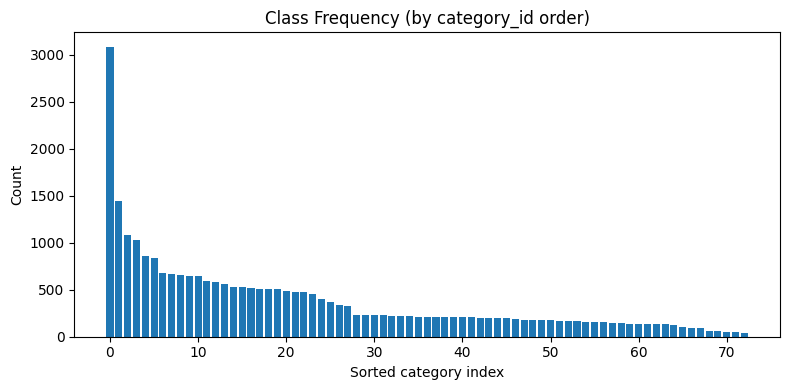

/tmp/ipython-input-3023921706.py:22: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3023921706.py:22: UserWarning: Glyph 45349 (\N{HANGUL SYLLABLE NEG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3023921706.py:22: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3023921706.py:22: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3023921706.py:22: UserWarning: Glyph 54532 (\N{HANGUL SYLLABLE PEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3023921706.py:22: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3023921706.py:22: UserWarning: Glyph 51008 (\N{HANGUL SYLLABLE EUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


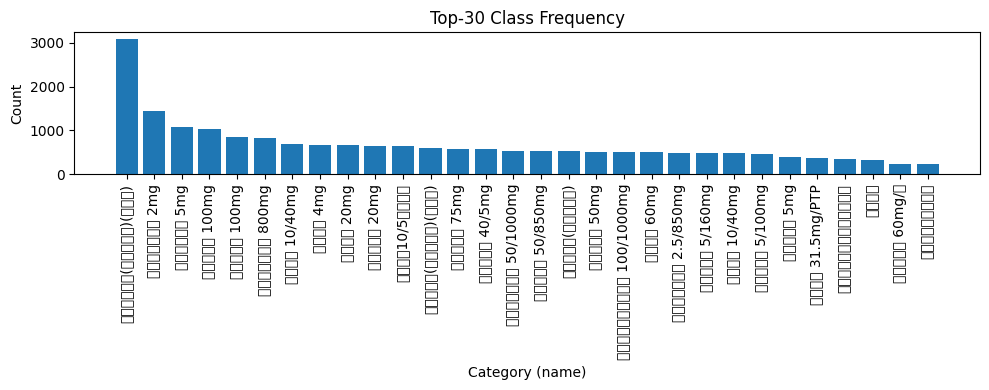

In [ ]:
# 전체 클래스 분포 (ID 기준)
plt.figure(figsize=(8,4))
plt.bar(range(len(cat_counts_sorted)), cat_counts_sorted)
plt.title("Class Frequency (by category_id order)")
plt.xlabel("Sorted category index")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Top-N 클래스 이름 라벨로 (이름이 긴 경우 많으면 N을 줄이세요)
TOPN = 30
top_names = cat_names_sorted[:TOPN]
top_counts = cat_counts_sorted[:TOPN]
x = np.arange(len(top_names))

plt.figure(figsize=(10,4))
plt.bar(x, top_counts)
plt.title(f"Top-{TOPN} Class Frequency")
plt.xlabel("Category (name)")
plt.ylabel("Count")
plt.xticks(x, top_names, rotation=90)
plt.tight_layout()
plt.show()


## 바운딩 박스 크기/면적/종횡비 분포

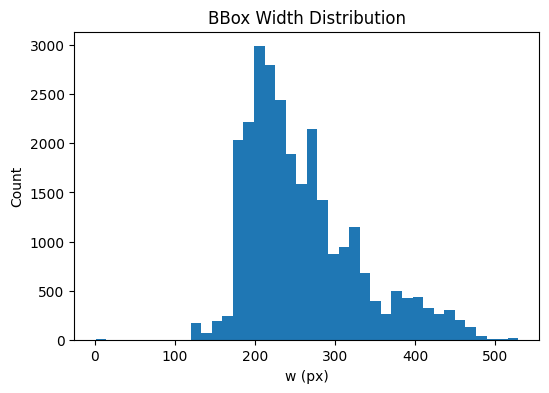

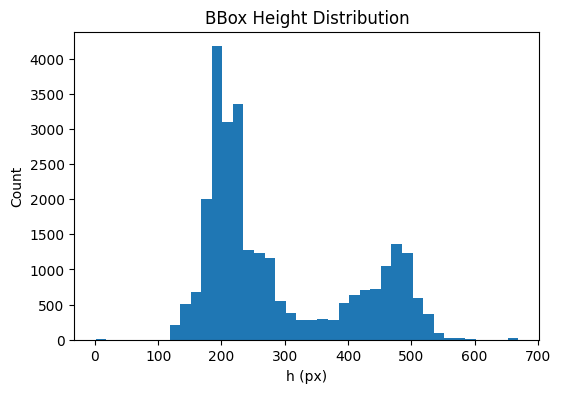

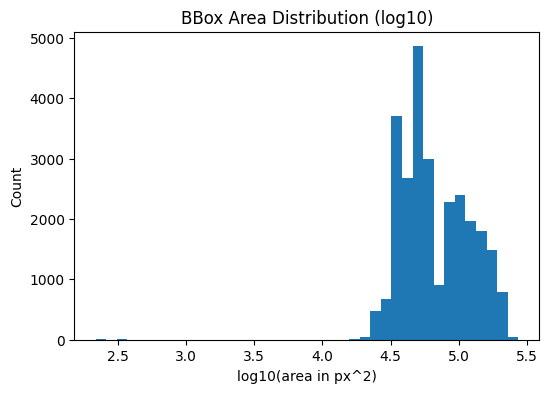

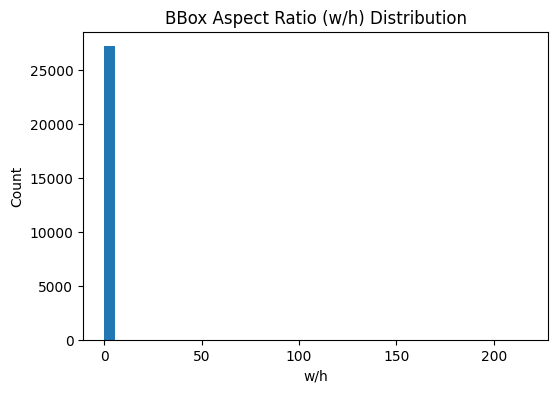

In [ ]:
if len(bboxes):
    # 너비 분포
    plt.figure(figsize=(6,4))
    plt.hist(bbox_w, bins=40)
    plt.title("BBox Width Distribution")
    plt.xlabel("w (px)")
    plt.ylabel("Count")
    plt.show()

    # 높이 분포
    plt.figure(figsize=(6,4))
    plt.hist(bbox_h, bins=40)
    plt.title("BBox Height Distribution")
    plt.xlabel("h (px)")
    plt.ylabel("Count")
    plt.show()

    # 면적 분포 (log10)
    plt.figure(figsize=(6,4))
    plt.hist(np.log10(np.clip(bbox_area, 1, None)), bins=40)
    plt.title("BBox Area Distribution (log10)")
    plt.xlabel("log10(area in px^2)")
    plt.ylabel("Count")
    plt.show()

    # 박스 종횡비
    plt.figure(figsize=(6,4))
    plt.hist(bbox_ar, bins=40)
    plt.title("BBox Aspect Ratio (w/h) Distribution")
    plt.xlabel("w/h")
    plt.ylabel("Count")
    plt.show()
else:
    print("어노테이션이 없어 bbox 분포 시각화를 건너뜁니다.")


## 이미지당 객체 수 분포 (최대 4개 검증)

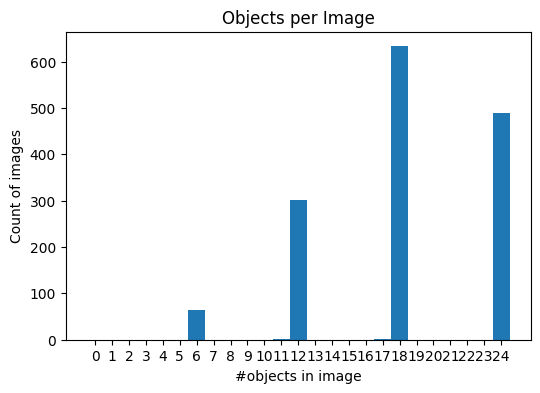

이미지당 객체 수 통계: mean= 18.236400268636668 min= 6 max= 24


In [ ]:
plt.figure(figsize=(6,4))
plt.hist(objs_per_img, bins=np.arange(0, objs_per_img.max()+2)-0.5)
plt.title("Objects per Image")
plt.xlabel("#objects in image")
plt.ylabel("Count of images")
plt.xticks(range(int(objs_per_img.max())+1))
plt.show()

if objs_per_img.size:
    print("이미지당 객체 수 통계:",
          "mean=", float(np.mean(objs_per_img)),
          "min=", int(np.min(objs_per_img)),
          "max=", int(np.max(objs_per_img)))


## 박스 중심 분포 Heatmap (정규화 좌표)

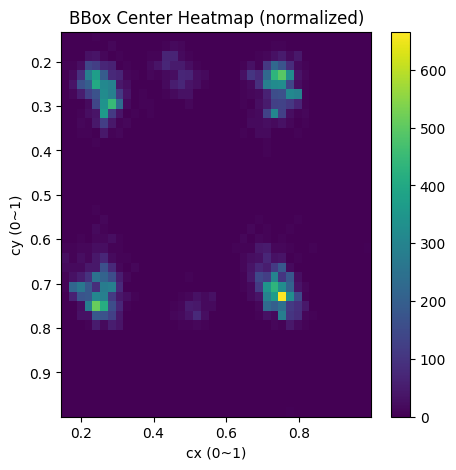

In [ ]:
# 서로 다른 이미지 크기를 공통 스케일로 보고 싶다면 중심을 [0,1] 범위로 정규화
centers_x = []
centers_y = []
for a in anns:
    im = img_by_id.get(a["image_id"])
    if im is None:
        continue
    x,y,w,h = a["bbox"]
    cx = (x + w/2) / max(im["width"], 1e-6)
    cy = (y + h/2) / max(im["height"], 1e-6)
    centers_x.append(cx)
    centers_y.append(cy)

centers_x = np.array(centers_x)
centers_y = np.array(centers_y)

if centers_x.size:
    plt.figure(figsize=(5,5))
    plt.hist2d(centers_x, centers_y, bins=40)
    plt.title("BBox Center Heatmap (normalized)")
    plt.xlabel("cx (0~1)")
    plt.ylabel("cy (0~1)")
    plt.colorbar()
    plt.gca().invert_yaxis()  # 이미지 좌표계 느낌을 주려면 뒤집기 (선택)
    plt.show()
else:
    print("박스 중심이 없어 heatmap을 건너뜁니다.")


## COCO 기준 Small/Medium/Large 비율
COCO의 기본 정의(픽셀 절대 크기): small < 32^2, medium < 96^2, 그 외 large

COCO S/M/L 분포
small : 10 (0.04%)
medium: 0 (0.00%)
large : 27144 (99.96%)


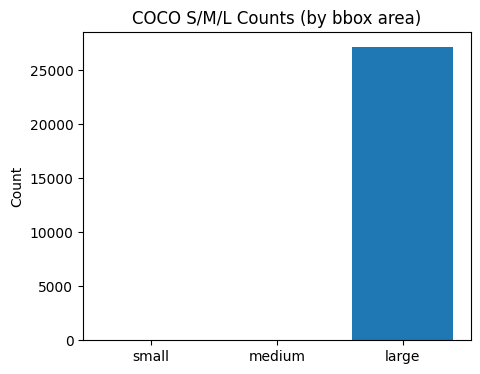

In [ ]:
if len(bbox_area):
    small  = np.sum(bbox_area <  32*32)
    medium = np.sum((bbox_area >= 32*32) & (bbox_area < 96*96))
    large  = np.sum(bbox_area >= 96*96)
    total  = len(bbox_area)

    print("COCO S/M/L 분포")
    print(f"small : {small} ({small/total*100:.2f}%)")
    print(f"medium: {medium} ({medium/total*100:.2f}%)")
    print(f"large : {large} ({large/total*100:.2f}%)")

    plt.figure(figsize=(5,4))
    plt.bar(["small","medium","large"], [small, medium, large])
    plt.title("COCO S/M/L Counts (by bbox area)")
    plt.ylabel("Count")
    plt.show()


## 샘플 이미지 박스

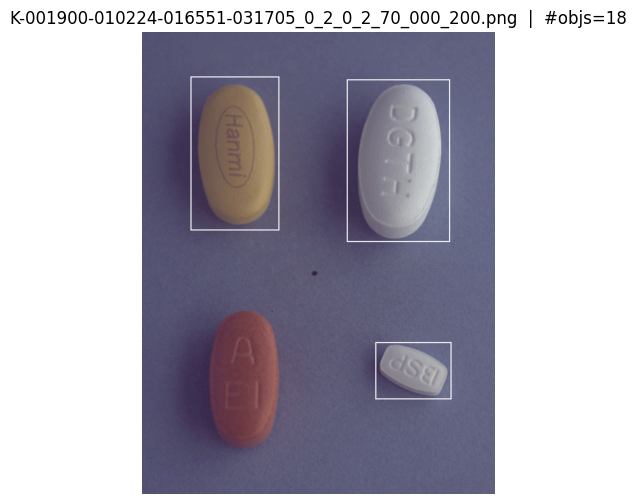

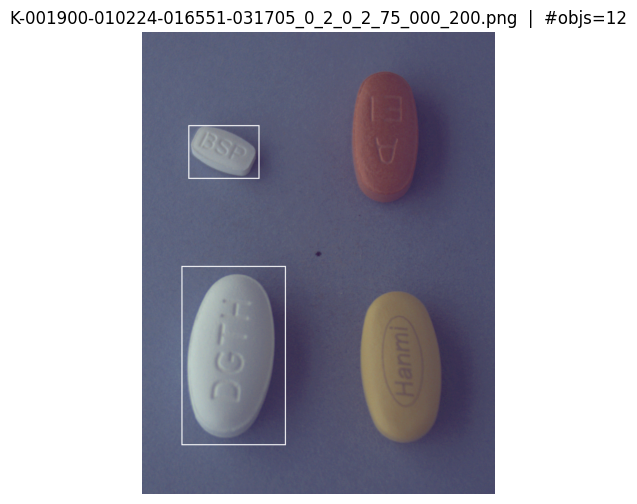

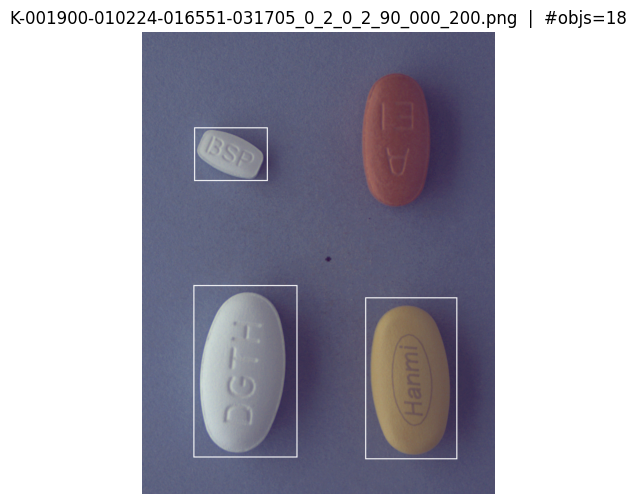

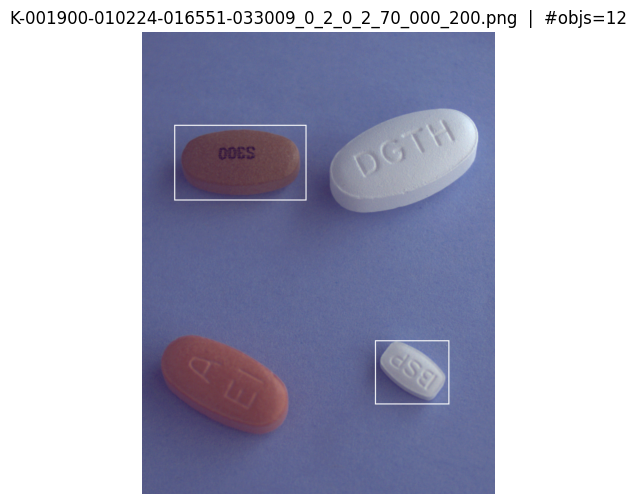

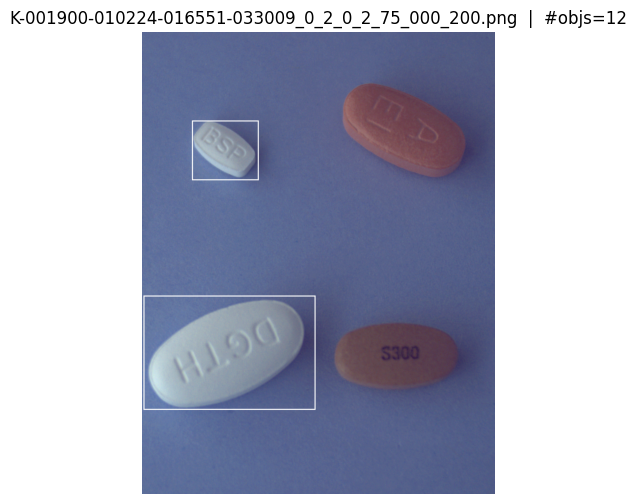

In [ ]:
from PIL import Image, ImageDraw
from functools import lru_cache

TRAIN_IMAGES_DIR = f"{BASE}/train_images"

@lru_cache(maxsize=1)
def build_image_index():
    index = defaultdict(list)
    for p in Path(TRAIN_IMAGES_DIR).rglob("*.png"):
        index[p.name.lower()].append(str(p))
    return index

def resolve_image_path(file_name_from_coco: str) -> str:
    p1 = Path(TRAIN_IMAGES_DIR) / file_name_from_coco
    if p1.exists():
        return str(p1)
    base = Path(file_name_from_coco).name.lower()
    idx = build_image_index()
    cand = idx.get(base, [])
    return cand[0] if len(cand) >= 1 else ""

def draw_boxes_on_image(image_path: str, ann_list):
    im = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(im)
    for a in ann_list:
        x,y,w,h = a["bbox"]
        draw.rectangle([x, y, x+w, y+h], outline=None, width=3)  # 색상 지정 X (기본)
    return im

# 예시: 객체가 있는 이미지 몇 장 시각화
samples = 5
shown = 0
for im in images:
    anns_this = [a for a in anns if a["image_id"] == im["id"]]
    if not anns_this:
        continue
    p = resolve_image_path(im["file_name"])
    if not p:
        continue
    vis = draw_boxes_on_image(p, anns_this)
    plt.figure(figsize=(6,6))
    plt.imshow(vis)
    plt.title(f"{im['file_name']}  |  #objs={len(anns_this)}")
    plt.axis("off")
    plt.show()
    shown += 1
    if shown >= samples:
        break


#COCO → YOLO 변환 + split + data.yaml

In [ ]:
# ===========================
# Step 2: COCO -> YOLO 전처리
# ===========================
import os, json, random, time, math
from pathlib import Path
from collections import defaultdict
from tqdm import tqdm

# --- 사용자 환경 경로 --------------------
BASE = "/content/drive/MyDrive/Codeit_AI_4th_Drug_image_CV_project/data"
TRAIN_IMAGES_DIR = f"{BASE}/train_images"
TRAIN_ANN_ROOT   = f"{BASE}/train_annotations"  # 여기서 COCO JSON 자동 탐색
TEST_IMAGES_DIR  = f"{BASE}/test_images"

WORKDIR          = "/content/ev_pill_yolo"
YOLO_DATASET_DIR = f"{WORKDIR}/_yolo_dataset"
SPLIT_LIST_DIR   = f"{WORKDIR}/_splits"
MAP_DIR          = f"{WORKDIR}/_maps"

VAL_RATIO = 0.15
SEED = 42

for d in [YOLO_DATASET_DIR, SPLIT_LIST_DIR, MAP_DIR]:
    os.makedirs(d, exist_ok=True)
for sub in ["images/train","images/val","labels/train","labels/val"]:
    os.makedirs(f"{YOLO_DATASET_DIR}/{sub}", exist_ok=True)

# --- COCO JSON 자동 선택 -----------------
def is_coco_like(js: dict) -> bool:
    return (
        isinstance(js, dict)
        and isinstance(js.get("images"), list)
        and isinstance(js.get("annotations"), list)
        and isinstance(js.get("categories"), list)
    )

def score_candidate(p: Path, js: dict) -> float:
    """이미지 수↑, 파일명 'instances' 포함 가산, 최신 수정 가산"""
    n_img = len(js.get("images", []))
    n_ann = len(js.get("annotations", []))
    name_boost = 0.15 if "instances" in p.name.lower() else 0.0
    try:
        mtime = p.stat().st_mtime
        age_days = max(0.0, (time.time() - mtime) / (3600*24))
        recency = 1.0 / (1.0 + math.log1p(age_days))
    except Exception:
        recency = 0.5
    return (n_img * 1.0) + (n_ann * 0.0005) + (name_boost * 100) + (recency * 10)

def auto_find_coco_json(root_dir: str):
    root = Path(root_dir)
    cands = []
    for p in tqdm(list(root.rglob("*.json")), desc="Scanning annotations", unit="json"):
        try:
            if p.stat().st_size < 200:
                continue
            with p.open("r") as f:
                js = json.load(f)
            if is_coco_like(js):
                cands.append((p, js, score_candidate(p, js)))
        except Exception:
            continue
    if not cands:
        raise FileNotFoundError("COCO 어노테이션(JSON)을 찾지 못했습니다. train_annotations 하부를 확인하세요.")
    cands.sort(key=lambda x: x[2], reverse=True)
    return str(cands[0][0]), cands[0][1]

TRAIN_ANN_PATH, coco = auto_find_coco_json(TRAIN_ANN_ROOT)
print(f"[OK] Selected COCO: {TRAIN_ANN_PATH}")
print(f"images={len(coco['images'])} | anns={len(coco['annotations'])} | cats={len(coco['categories'])}")

# --- 카테고리 매핑 -----------------------
categories = coco["categories"]
cat_id_list_sorted = sorted([c["id"] for c in categories])
catid2yidx = {cid: i for i, cid in enumerate(cat_id_list_sorted)}
yidx2catid = {i: cid for cid, i in catid2yidx.items()}
names = []
id2name = {c["id"]: c.get("name", str(c["id"])) for c in categories}
for i in range(len(yidx2catid)):
    names.append(id2name.get(yidx2catid[i], str(yidx2catid[i])))

with open(f"{MAP_DIR}/catid2yidx.json", "w") as f: json.dump(catid2yidx, f)
with open(f"{MAP_DIR}/yidx2catid.json", "w") as f: json.dump(yidx2catid, f)
with open(f"{MAP_DIR}/names.json",      "w") as f: json.dump(names, f, ensure_ascii=False)

print(f"[OK] Saved mappings to {MAP_DIR} (num_classes={len(names)})")


Scanning annotations: 100%|██████████| 4527/4527 [00:10<00:00, 442.18json/s]

[OK] Selected COCO: /content/drive/MyDrive/Codeit_AI_4th_Drug_image_CV_project/data/train_annotations/_merged/annotations_train_merged.json
images=1489 | anns=27154 | cats=73
[OK] Saved mappings to /content/ev_pill_yolo/_maps (num_classes=73)


In [ ]:

# --- 이미지 경로 안전 해석 ----------------
from functools import lru_cache
@lru_cache(maxsize=1)
def build_image_index():
    idx = defaultdict(list)
    for p in Path(TRAIN_IMAGES_DIR).rglob("*.png"):
        idx[p.name.lower()].append(str(p))
    return idx

def resolve_image_path(file_name_from_coco: str) -> str:
    # 1) file_name이 서브경로 포함인 경우
    p1 = Path(TRAIN_IMAGES_DIR) / file_name_from_coco
    if p1.exists():
        return str(p1)
    # 2) 베이스네임으로 탐색
    base = Path(file_name_from_coco).name.lower()
    cand = build_image_index().get(base, [])
    return cand[0] if cand else ""

# --- split 생성 --------------------------
all_images = list(coco["images"])
random.Random(SEED).shuffle(all_images)
n_val = int(len(all_images) * VAL_RATIO)
val_ids = set(im["id"] for im in all_images[:n_val])
train_ids = set(im["id"] for im in all_images[n_val:])

with open(f"{SPLIT_LIST_DIR}/train_img_ids.txt", "w") as f:
    f.write("\n".join(map(str, sorted(train_ids))))
with open(f"{SPLIT_LIST_DIR}/val_img_ids.txt", "w") as f:
    f.write("\n".join(map(str, sorted(val_ids))))
print(f"[OK] Split saved: train={len(train_ids)}, val={len(val_ids)}")


[OK] Split saved: train=1266, val=223


In [ ]:

# --- COCO → YOLO 변환 --------------------
img_by_id = {im["id"]: im for im in coco["images"]}
anns_by_img = defaultdict(list)
for a in coco["annotations"]:
    anns_by_img[a["image_id"]].append(a)

def coco2yolo_bbox(b, W, H):
    x,y,w,h = b
    cx = (x + w/2.0) / max(W, 1e-6)
    cy = (y + h/2.0) / max(H, 1e-6)
    return [cx, cy, w/max(W,1e-6), h/max(H,1e-6)]

from shutil import copy2

drop_missing_img = 0
converted = 0
copied = 0

for im in tqdm(coco["images"], desc="Converting COCO -> YOLO", unit="img"):
    img_src = resolve_image_path(im["file_name"])
    subset = "val" if im["id"] in val_ids else "train"
    # 이미지 복사
    if img_src:
        dst_img = f"{YOLO_DATASET_DIR}/images/{subset}/{Path(im['file_name']).name}"
        if not Path(dst_img).exists():
            os.makedirs(Path(dst_img).parent, exist_ok=True)
            copy2(img_src, dst_img)
            copied += 1
    else:
        drop_missing_img += 1
        # 그래도 라벨 파일은 생성하지 않음(이미지 없음)
        continue

    # YOLO 라벨 작성 (없으면 빈 파일)
    W, H = im["width"], im["height"]
    lines = []
    for a in anns_by_img.get(im["id"], []):
        yidx = catid2yidx[a["category_id"]]
        cx, cy, ww, hh = coco2yolo_bbox(a["bbox"], W, H)
        lines.append(f"{yidx} {cx:.6f} {cy:.6f} {ww:.6f} {hh:.6f}")
        converted += 1

    label_path = f"{YOLO_DATASET_DIR}/labels/{subset}/{Path(im['file_name']).stem}.txt"
    with open(label_path, "w") as f:
        f.write("\n".join(lines))

print(f"[OK] Images copied: {copied}, Missing images: {drop_missing_img}, Annotations converted: {converted}")



Converting COCO -> YOLO: 100%|██████████| 1489/1489 [15:49<00:00,  1.57img/s]

[OK] Images copied: 1489, Missing images: 0, Annotations converted: 27154


In [ ]:
# --- data.yaml 생성 ----------------------
data_yaml = f"""path: {YOLO_DATASET_DIR}
train: images/train
val: images/val
test: {TEST_IMAGES_DIR}
names: {names}
"""
with open(f"{WORKDIR}/data.yaml", "w", encoding="utf-8") as f:
    f.write(data_yaml)

print(f"[OK] data.yaml saved -> {WORKDIR}/data.yaml")
print("Preview:\n", open(f"{WORKDIR}/data.yaml","r",encoding="utf-8").read())


[OK] data.yaml saved -> /content/ev_pill_yolo/data.yaml
Preview:
 path: /content/ev_pill_yolo/_yolo_dataset
train: images/train
val: images/val
test: /content/drive/MyDrive/Codeit_AI_4th_Drug_image_CV_project/data/test_images
names: ['보령부스파정 5mg', '동아가바펜틴정 800mg', '낙소졸정 500/20mg', '신바로정', '가바토파정 100mg', '란스톤엘에프디티정 30mg', '펠루비정(펠루비프로펜)', '울트라셋이알서방정', '비모보정 500/20mg', '레일라정', '스토가정 10mg', '라비에트정 20mg', '놀텍정 10mg', '에스원엠프정 20mg', '케이캡정 50mg', '뮤테란캡슐 100mg', '알드린정', '타이레놀정500mg', '삐콤씨에프정 618.6mg/병', '다보타민큐정 10mg/병', '트루비타정 60mg/병', '메가파워정 90mg/병', '비타비백정 100mg/병', '타이레놀이알서방정(아세트아미노펜)(수출용)', '리렉스펜정 300mg/PTP', '써스펜8시간이알서방정 650mg', '맥시부펜이알정 300mg', '삼남건조수산화알루미늄겔정', '큐시드정 31.5mg/PTP', '일양하이트린정 2mg', '뉴로메드정(옥시라세탐)', '리피토정 20mg', '크레스토정 20mg', '오마코연질캡슐(오메가-3-산에틸에스테르90)', '플라빅스정 75mg', '아토르바정 10mg', '리피로우정 20mg', '리바로정 4mg', '아토젯정 10/40mg', '로수젯정10/5밀리그램', '로수바미브정 10/20mg', '에빅사정(메만틴염산염)(비매품)', '리리카캡슐 150mg', '종근당글리아티린연질캡슐(콜린알포세레이트)', '콜리네이트연질캡슐 400mg', '마도파정', '아질렉트정(라사길린메실산염)', '글리아타민연질캡슐', '글

# High-Precision YOLO
1) 학습 세팅 (정밀 바운딩 박스 중심)

고해상도 학습: imgsz=1280 (여유 되면 1536까지 시도)

박스 손실 가중↑, DFL↑: 정밀한 경계 상자 학습에 유리

과도한 색/기하 증강 ↓: 약품 색/형태 왜곡 최소화

마지막 구간 close_mosaic: 모자이크 끄고 실 이미지 분포에 맞춰 박스 피팅

In [ ]:
from ultralytics import YOLO
import torch, os

WORKDIR = "/content/ev_pill_yolo"
DATA_YAML = f"{WORKDIR}/data.yaml"
MODEL = "yolo11s.pt"

# 🔒 W&B가 켜져 있어도 프로젝트명은 슬래시 없이!
WB_PROJECT = "ev_pill"    # <= 문자열만, 슬래시 X
RUN_NAME   = "train_hp"

# 저장 경로는 save_dir로 직접 지정 (project/name와 분리)
SAVE_DIR = f"{WORKDIR}/runs/{RUN_NAME}"

model = YOLO(MODEL)

results = model.train(
    data=DATA_YAML,
    epochs=40,
    batch=6 if torch.cuda.is_available() else 4,
    imgsz=992,
    patience=30,
    device=0 if torch.cuda.is_available() else "cpu",

    # ✅ 여기 핵심: project에는 문자열만, 실제 저장 경로는 save_dir에 지정
    project=WB_PROJECT,   # W&B용 안전한 문자열
    name=RUN_NAME,
    save_dir=SAVE_DIR,    # 실제 파일 저장 경로

    deterministic=True,
    rect=True, cache=True,
    optimizer="AdamW", cos_lr=True,
    lr0=0.0015, lrf=0.02, momentum=0.9, weight_decay=0.0005, warmup_epochs=3.0,
    box=10.0, cls=0.4, dfl=2.0,
    hsv_h=0.010, hsv_s=0.40, hsv_v=0.20,
    degrees=5.0, translate=0.05, scale=0.10, shear=0.0, perspective=0.0,
    fliplr=0.5, flipud=0.0,
    mosaic=0.30, mixup=0.0, close_mosaic=10,
    workers=2, val=True, plots=True,
)


100%|██████████| 18.4M/18.4M [00:00<00:00, 353MB/s]


New https://pypi.org/project/ultralytics/8.3.203 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.20 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/ev_pill_yolo/data.yaml, epochs=40, time=None, patience=30, batch=6, imgsz=992, save=True, save_period=-1, cache=True, device=0, workers=2, project=ev_pill, name=train_hp, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=True, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fr

100%|██████████| 22.2M/22.2M [00:01<00:00, 22.9MB/s]


Overriding model.yaml nc=80 with nc=73

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180672  ultralytic

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: brookinljy (brookinljy-inha-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 462MB/s]


AMP: checks passed ✅


train: Scanning /content/ev_pill_yolo/_yolo_dataset/labels/train... 1266 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1266/1266 [00:02<00:00, 557.36it/s]

train: WARNING ⚠️ /content/ev_pill_yolo/_yolo_dataset/images/train/K-001900-010224-016551-031705_0_2_0_2_70_000_200.png: 15 duplicate labels removed
train: WARNING ⚠️ /content/ev_pill_yolo/_yolo_dataset/images/train/K-001900-010224-016551-031705_0_2_0_2_75_000_200.png: 10 duplicate labels removed
train: WARNING ⚠️ /content/ev_pill_yolo/_yolo_dataset/images/train/K-001900-010224-016551-031705_0_2_0_2_90_000_200.png: 15 duplicate labels removed
train: WARNING ⚠️ /content/ev_pill_yolo/_yolo_dataset/images/train/K-001900-010224-016551-033009_0_2_0_2_70_000_200.png: 10 duplicate labels removed
train: WARNING ⚠️ /content/ev_pill_yolo/_yolo_dataset/images/train/K-001900-010224-016551-033009_0_2_0_2_75_000_200.png: 10 duplicate labels removed
train: WARNING ⚠️ /content/ev_pill_yolo/_yolo_dataset/images/train/K-001900-010224-016551-033009_0_2_0_2_90_000_200.png: 15 duplicate labels removed
train: WARNING ⚠️ /content/ev_pill_yolo/_yolo_dataset/images/train/K-001900-016548-018110-021026_0_2_0_2_7

WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (2.7GB RAM): 100%|██████████| 1266/1266 [00:08<00:00, 149.49it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
WARNING ⚠️ 'rect=True' is incompatible with DataLoader shuffle, setting shuffle=False


/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /content/ev_pill_yolo/_yolo_dataset/labels/val... 223 images, 0 backgrounds, 0 corrupt: 100%|██████████| 223/223 [00:00<00:00, 495.67it/s]

val: WARNING ⚠️ /content/ev_pill_yolo/_yolo_dataset/images/val/K-001900-016548-018110-027926_0_2_0_2_70_000_200.png: 15 duplicate labels removed
val: WARNING ⚠️ /content/ev_pill_yolo/_yolo_dataset/images/val/K-001900-016548-018110-029451_0_2_0_2_70_000_200.png: 20 duplicate labels removed
val: WARNING ⚠️ /content/ev_pill_yolo/_yolo_dataset/images/val/K-001900-016548-019607-021026_0_2_0_2_70_000_200.png: 10 duplicate labels removed
val: WARNING ⚠️ /content/ev_pill_yolo/_yolo_dataset/images/val/K-001900-016548-019607-029345_0_2_0_2_70_000_200.png: 5 duplicate labels removed
val: WARNING ⚠️ /content/ev_pill_yolo/_yolo_dataset/images/val/K-001900-016548-019607-029451_0_2_0_2_75_000_200.png: 20 duplicate labels removed
val: WARNING ⚠️ /content/ev_pill_yolo/_yolo_dataset/images/val/K-001900-016548-019607-031705_0_2_0_2_70_000_200.png: 15 duplicate labels removed
val: WARNING ⚠️ /content/ev_pill_yolo/_yolo_dataset/images/val/K-001900-016548-021771-029345_0_2_0_2_75_000_200.png: 15 duplicate l

WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.5GB RAM): 100%|██████████| 223/223 [00:01<00:00, 153.01it/s]


Plotting labels to ev_pill/train_hp/labels.jpg... 
optimizer: AdamW(lr=0.0015, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.000515625), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 992 train, 992 val
Using 2 dataloader workers
Logging results to ev_pill/train_hp
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      3.34G      2.676      6.834      3.551         16        768:   1%|          | 2/211 [00:09<13:36,  3.91s/it]

       1/40      3.34G       2.69      6.776       3.34         20        768:   2%|▏         | 4/211 [00:09<04:56,  1.43s/it]
100%|██████████| 755k/755k [00:00<00:00, 160MB/s]
       1/40      3.38G     0.8879      2.686      1.418         21        768: 100%|██████████| 211/211 [00:51<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.17it/s]

                   all        223        679     0.0137      0.361     0.0685     0.0534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      3.32G     0.8516      2.677      1.344         21        768: 100%|██████████| 211/211 [00:41<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  6.13it/s]

                   all        223        679      0.434     0.0589     0.0493     0.0403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      3.32G     0.8697       2.71       1.35         21        768: 100%|██████████| 211/211 [00:41<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  6.16it/s]


                   all        223        679      0.445      0.199     0.0696     0.0595

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      3.31G     0.8868       2.61      1.367         21        768: 100%|██████████| 211/211 [00:41<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.34it/s]

                   all        223        679      0.572      0.235        0.1     0.0923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      3.31G      0.841      2.247      1.334         21        768: 100%|██████████| 211/211 [00:41<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.33it/s]


                   all        223        679      0.554      0.192     0.0835     0.0643

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      3.32G     0.8644      2.054      1.359         21        768: 100%|██████████| 211/211 [00:41<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.46it/s]

                   all        223        679      0.705      0.209      0.132      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      3.32G     0.8252      1.958      1.327         21        768: 100%|██████████| 211/211 [00:41<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.40it/s]

                   all        223        679      0.719      0.189      0.183      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      3.32G     0.8049      1.991       1.31         21        768: 100%|██████████| 211/211 [00:41<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.40it/s]


                   all        223        679      0.571      0.197      0.103     0.0865

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40       3.3G     0.7594      1.879      1.284         21        768: 100%|██████████| 211/211 [00:41<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.44it/s]

                   all        223        679      0.562       0.22      0.151      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      3.32G     0.7861      1.869      1.299         21        768: 100%|██████████| 211/211 [00:41<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.45it/s]

                   all        223        679      0.575      0.302      0.162      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      3.32G     0.7752      1.719      1.282         21        768: 100%|██████████| 211/211 [00:41<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.48it/s]

                   all        223        679      0.706      0.262      0.176      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      3.31G     0.7849      1.658      1.284         21        768: 100%|██████████| 211/211 [00:41<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.39it/s]

                   all        223        679      0.703       0.21      0.198      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      3.31G     0.7365       1.77      1.259         21        768: 100%|██████████| 211/211 [00:41<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.48it/s]

                   all        223        679      0.746      0.242       0.23      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      3.31G     0.7049      1.666      1.244         21        768: 100%|██████████| 211/211 [00:41<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.50it/s]

                   all        223        679      0.731      0.272      0.292      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      3.32G      0.707      1.554      1.232         21        768: 100%|██████████| 211/211 [00:41<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.46it/s]

                   all        223        679      0.516      0.424       0.32      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      3.32G     0.6935       1.53      1.223         21        768: 100%|██████████| 211/211 [00:41<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.53it/s]

                   all        223        679      0.548      0.362      0.288      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      3.32G     0.6953      1.548      1.219         21        768: 100%|██████████| 211/211 [00:41<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.51it/s]

                   all        223        679      0.467      0.416      0.322      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      3.31G     0.6686      1.482      1.208         21        768: 100%|██████████| 211/211 [00:41<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.50it/s]

                   all        223        679      0.563       0.47      0.375      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      3.31G     0.6674      1.535      1.204         21        768: 100%|██████████| 211/211 [00:41<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.49it/s]

                   all        223        679      0.721      0.321      0.385      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      3.29G     0.6678      1.421      1.208         21        768: 100%|██████████| 211/211 [00:41<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.50it/s]

                   all        223        679      0.433      0.576      0.444      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      3.31G     0.6334      1.319      1.191         21        768: 100%|██████████| 211/211 [00:41<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.53it/s]

                   all        223        679      0.688      0.409      0.457      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      3.31G     0.6627       1.26      1.201         21        768: 100%|██████████| 211/211 [00:41<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.55it/s]

                   all        223        679      0.452      0.494      0.449      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      3.32G     0.6344      1.292      1.185         21        768: 100%|██████████| 211/211 [00:41<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.51it/s]

                   all        223        679      0.506      0.576      0.477      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      3.31G     0.6267      1.412      1.184         21        768: 100%|██████████| 211/211 [00:41<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.54it/s]

                   all        223        679      0.368       0.65       0.51      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      3.31G     0.6356      1.226      1.185         21        768: 100%|██████████| 211/211 [00:41<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.52it/s]

                   all        223        679      0.506      0.534      0.509      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      3.31G     0.6169      1.178       1.18         21        768: 100%|██████████| 211/211 [00:41<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.41it/s]

                   all        223        679      0.536      0.587      0.529      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      3.31G     0.5974      1.079      1.164         21        768: 100%|██████████| 211/211 [00:41<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.50it/s]

                   all        223        679      0.445      0.631      0.559      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      3.32G      0.577      1.062      1.161         21        768: 100%|██████████| 211/211 [00:41<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.53it/s]

                   all        223        679       0.51       0.61      0.535      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      3.31G     0.5799     0.9884      1.157         21        768: 100%|██████████| 211/211 [00:41<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.50it/s]

                   all        223        679       0.63       0.51      0.608      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      3.32G     0.5749     0.9751       1.16         21        768: 100%|██████████| 211/211 [00:41<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.53it/s]

                   all        223        679      0.523      0.628      0.596      0.529


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40       3.3G     0.5722     0.9353      1.154         21        768: 100%|██████████| 211/211 [00:41<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.51it/s]

                   all        223        679      0.527      0.662      0.597      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      3.32G     0.5652     0.9025      1.145         21        768: 100%|██████████| 211/211 [00:41<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.51it/s]

                   all        223        679      0.543      0.642      0.607      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      3.32G       0.57     0.8617      1.152         21        768: 100%|██████████| 211/211 [00:41<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.56it/s]

                   all        223        679      0.513      0.625      0.601      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      3.31G     0.5509     0.8367      1.146         21        768: 100%|██████████| 211/211 [00:41<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.51it/s]

                   all        223        679      0.487       0.63      0.613      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      3.31G     0.5561     0.8278      1.152         21        768: 100%|██████████| 211/211 [00:41<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.58it/s]

                   all        223        679      0.463      0.706      0.625      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40       3.3G     0.5453     0.8109      1.145         21        768: 100%|██████████| 211/211 [00:41<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.56it/s]

                   all        223        679      0.478      0.725      0.632      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      3.31G     0.5368     0.7762      1.139         21        768: 100%|██████████| 211/211 [00:41<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.51it/s]

                   all        223        679      0.472      0.754      0.631      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      3.31G     0.5379     0.7793      1.137         21        768: 100%|██████████| 211/211 [00:41<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.56it/s]

                   all        223        679      0.497      0.728      0.631       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      3.32G     0.5363     0.7635      1.135         21        768: 100%|██████████| 211/211 [00:41<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.56it/s]

                   all        223        679      0.499      0.697      0.626      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      3.31G     0.5313     0.7587      1.132         21        768: 100%|██████████| 211/211 [00:41<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.53it/s]

                   all        223        679      0.517      0.693      0.638      0.554



40 epochs completed in 0.513 hours.
Optimizer stripped from ev_pill/train_hp/weights/last.pt, 19.3MB
Optimizer stripped from ev_pill/train_hp/weights/best.pt, 19.3MB

Validating ev_pill/train_hp/weights/best.pt...
Ultralytics 8.3.20 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 238 layers, 9,441,051 parameters, 0 gradients, 21.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.79it/s]


                   all        223        679      0.478      0.727      0.631       0.56
            보령부스파정 5mg         26         26      0.689          1      0.833       0.75
         동아가바펜틴정 800mg         16         16      0.508          1      0.887      0.781
         낙소졸정 500/20mg          5          5      0.199          1      0.895      0.796
                  신바로정          6          6      0.335      0.833      0.895       0.74
           가바토파정 100mg         18         18      0.577      0.944      0.725      0.647
        란스톤엘에프디티정 30mg          2          2          1          0      0.663      0.597
          펠루비정(펠루비프로펜)          6          6       0.19      0.833      0.222      0.207
             울트라셋이알서방정          5          5      0.275          1      0.862      0.743
         비모보정 500/20mg          6          6      0.266          1      0.551      0.496
                  레일라정          7          7      0.206      0.714       0.27      0.244
             스토가정 10m

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:432: UserWarning: Glyph 48372 (\N{HANGUL SYLLABLE BO}) missing from font(s) DejaVu Sans.
  fig.savefig(plot_fname, dpi=250)
/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:432: UserWarning: Glyph 47161 (\N{HANGUL SYLLABLE RYEONG}) missing from font(s) DejaVu Sans.
  fig.savefig(plot_fname, dpi=250)
/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:432: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from font(s) DejaVu Sans.
  fig.savefig(plot_fname, dpi=250)
/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:432: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  fig.savefig(plot_fname, dpi=250)
/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:432: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  fig.savefig(plot_fname, dpi=250)
/usr/local/lib/python3.12/dist

Speed: 0.4ms preprocess, 7.9ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to ev_pill/train_hp


## 시각화

###학습 결과 플롯/메트릭

Ultralytics가 자동 저장해둔 PR 커브, Confusion Matrix, 학습 곡선

✅ Detected RUN_DIR: /content/ev_pill/train_hp
   best.pt exists: True
PNG plots found: 7
show: /content/ev_pill/train_hp/F1_curve.png


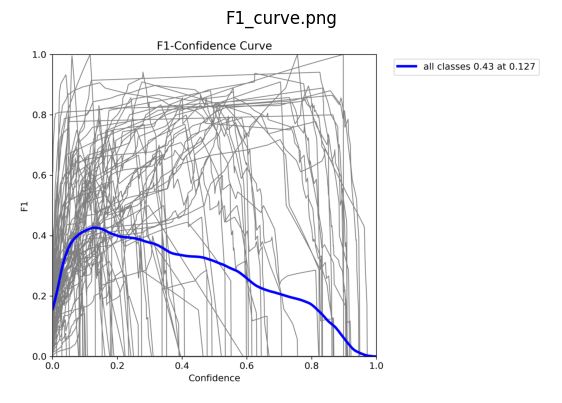

show: /content/ev_pill/train_hp/PR_curve.png


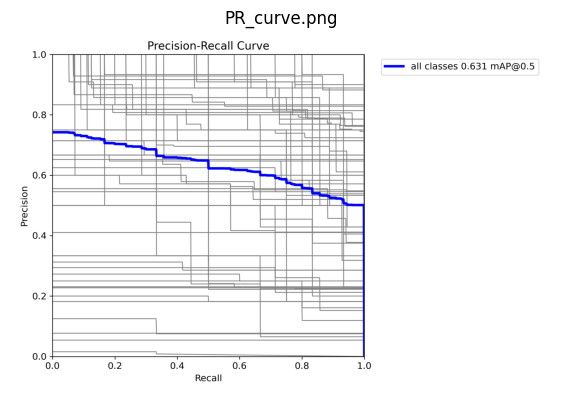

show: /content/ev_pill/train_hp/P_curve.png


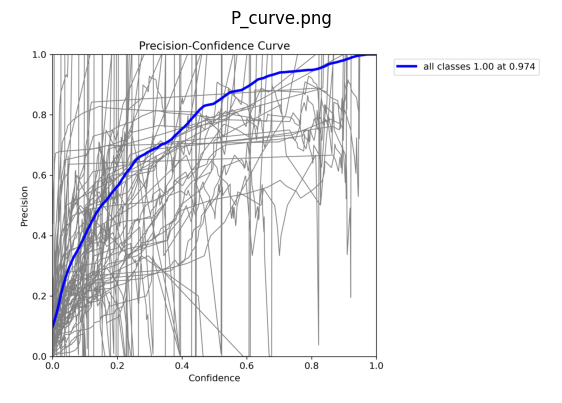

show: /content/ev_pill/train_hp/R_curve.png


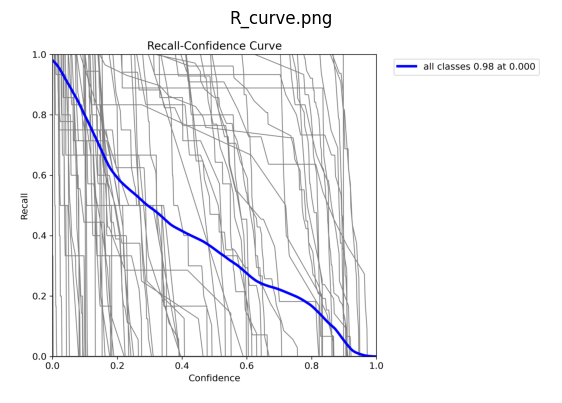

show: /content/ev_pill/train_hp/confusion_matrix.png


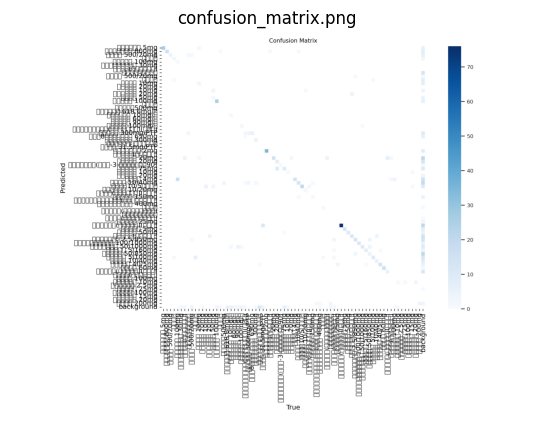

show: /content/ev_pill/train_hp/confusion_matrix_normalized.png


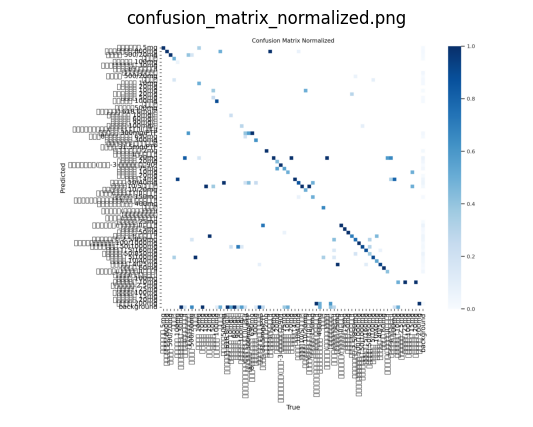

In [ ]:
# ✅ best.pt 자동탐색 → RUN_DIR 설정 → 플롯 미리보기
import os, glob
from pathlib import Path
import matplotlib.pyplot as plt

# 1) best.pt 통합 탐색 (여러 후보 루트)
SEARCH_ROOTS = [
    "/content/ev_pill_yolo",
    "/content/ev_pill",
    "/content",
    "/content/drive/MyDrive",
    "/content/drive",
    ".",
]
hits = []
for root in SEARCH_ROOTS:
    hits += glob.glob(os.path.join(root, "**/weights/best.pt"), recursive=True)

if not hits:
    # 디버그: /content 내용 보여주기
    print("⚠️ best.pt를 찾지 못했습니다. /content 목록을 출력합니다:")
    os.system("ls -lah /content")
    raise FileNotFoundError("훈련 결과(…/weights/best.pt)를 찾지 못했습니다. 실제 저장 경로를 확인하세요.")

# 2) 가장 최근 run 선택 (원하면 이름 가중치로 우선순위)
def sort_key(p):
    P = Path(p)
    # 'train_hp2'를 더 선호 (있으면 보너스)
    bonus = 1 if "train_hp2" in str(P) else 0
    return (P.stat().st_mtime, bonus)

best_pt = sorted(set(hits), key=sort_key, reverse=True)[0]
RUN_DIR = Path(best_pt).parent.parent
print("✅ Detected RUN_DIR:", RUN_DIR)
print("   best.pt exists:", Path(best_pt).exists())

# 3) 저장된 플롯 미리보기 (없으면 검증으로 생성하세요)
pngs = sorted(glob.glob(str(RUN_DIR / "**/*.png"), recursive=True))
print("PNG plots found:", len(pngs))
for pf in pngs[:6]:
    print("show:", pf)
    img = plt.imread(pf)
    plt.figure(figsize=(7,5))
    plt.imshow(img); plt.title(Path(pf).name); plt.axis("off")
    plt.show()


PNG plots found: 7


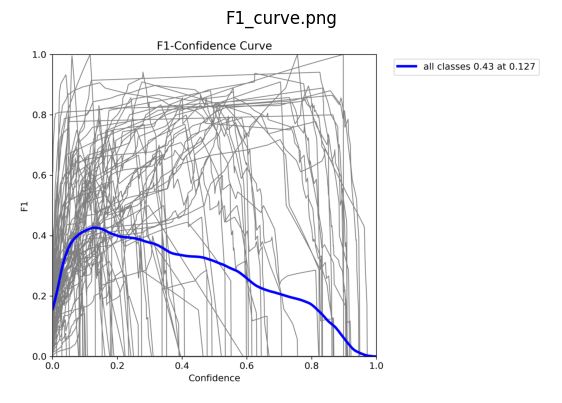

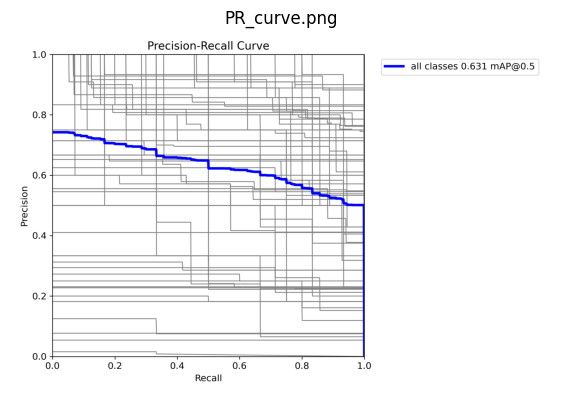

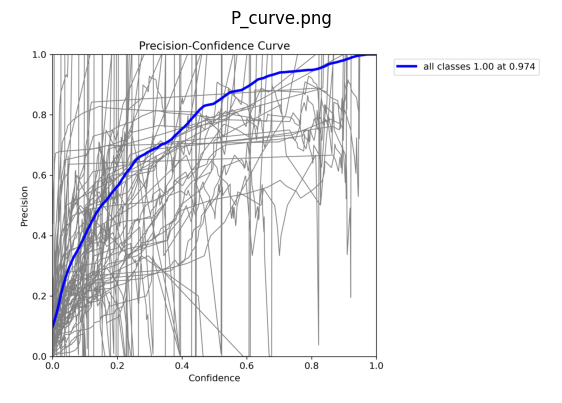

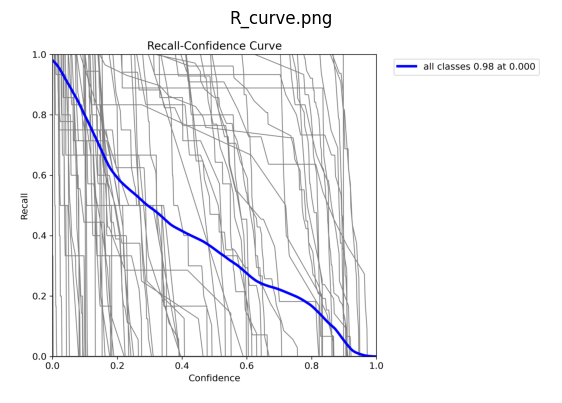

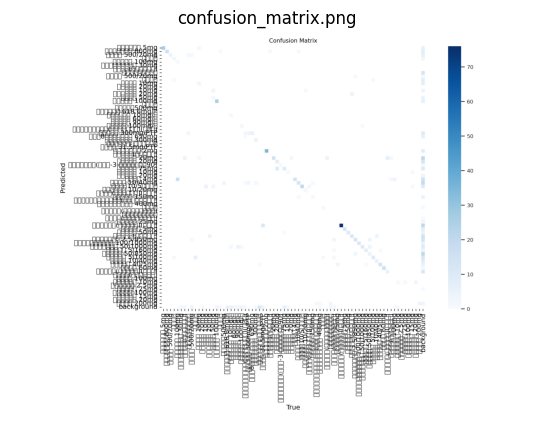

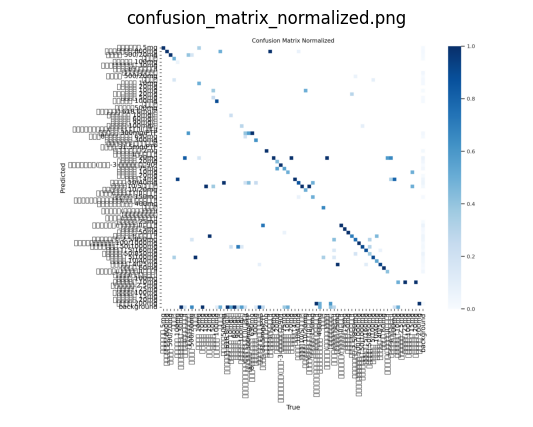

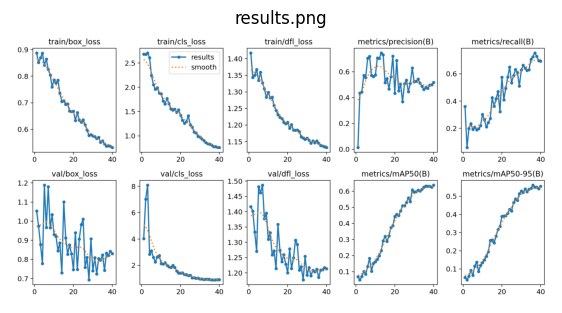

In [ ]:
from pathlib import Path
import glob, matplotlib.pyplot as plt

RUN_DIR = Path("/content/ev_pill/train_hp")  # 방금 확인된 경로 사용
pngs = sorted(glob.glob(str(RUN_DIR / "**/*.png"), recursive=True))
print("PNG plots found:", len(pngs))

for pf in pngs:
    img = plt.imread(pf)
    plt.figure(figsize=(7,5))
    plt.imshow(img)
    plt.title(Path(pf).name)
    plt.axis("off")
    plt.show()


Using RUN_DIR: /content/ev_pill/train_hp
Missing plots: None


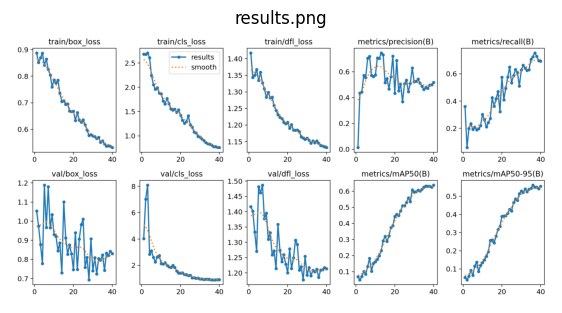

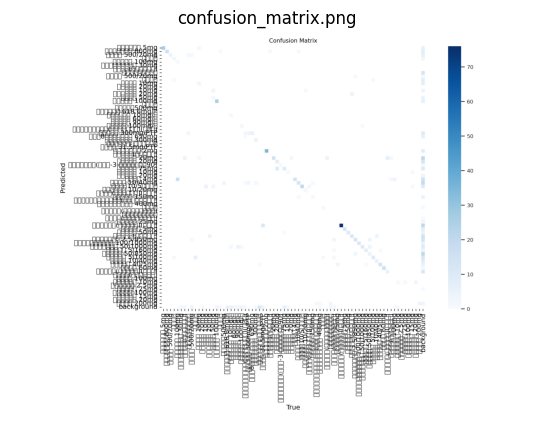

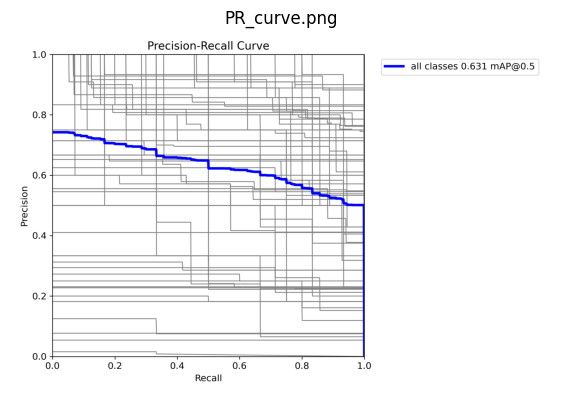

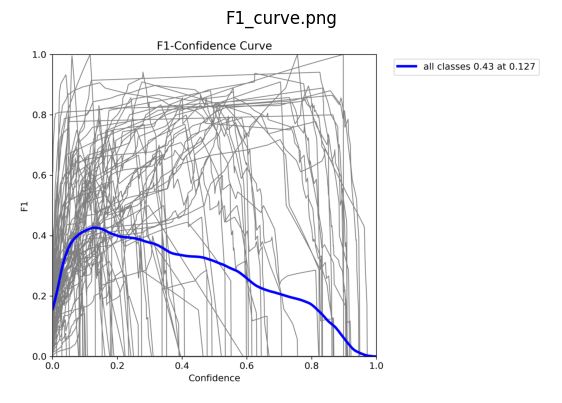

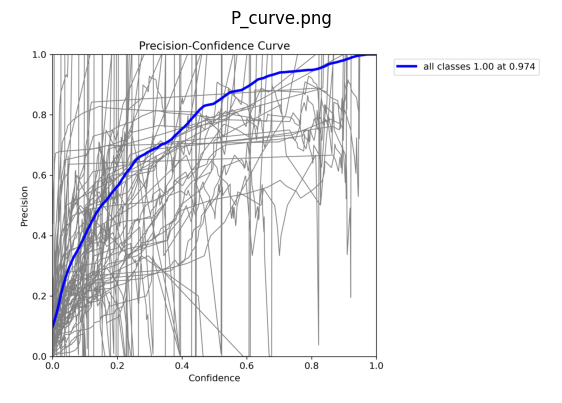

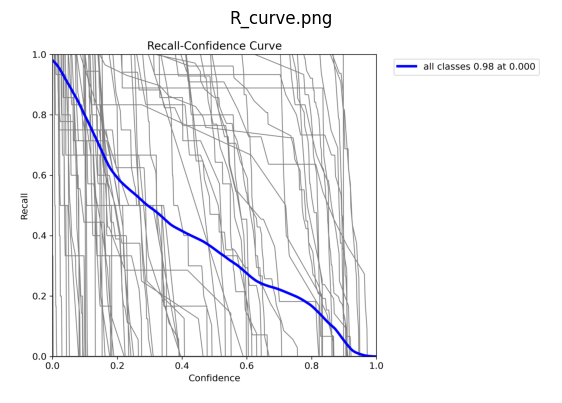

Displayed 6/6 plots.


In [ ]:
# ✅ 최신 run 자동 탐색 → 플롯 재생성(PR/F1/P/R/CM) → 화면 표시
import os, glob
from pathlib import Path
import matplotlib.pyplot as plt

# 0) 우선 네가 적은 기본 경로도 후보에 포함
DEFAULT = Path(" /content/ev_pill/train_hp")

# 1) 최신 run 디렉토리 자동 탐색 (weights/best.pt 기준)
SEARCH_ROOTS = ["/content/ev_pill_yolo", "/content", "ev_pill", "."]
candidates = []
if DEFAULT.exists():
    candidates.append(DEFAULT)

for root in SEARCH_ROOTS:
    hits = glob.glob(os.path.join(root, "**/weights/best.pt"), recursive=True)
    for hp in hits:
        candidates.append(Path(hp).parent.parent)  # .../weights/best.pt -> run_dir

# 중복 제거 + 최근순 정렬
candidates = sorted(set(candidates), key=lambda p: p.stat().st_mtime, reverse=True)
assert candidates, "학습 결과 폴더(…/weights/best.pt)를 찾지 못했습니다."
RUN_DIR = candidates[0]
BEST_PT = RUN_DIR / "weights" / "best.pt"
print("Using RUN_DIR:", RUN_DIR)

# 2) 필요한 플롯 목록
want = ["results.png", "confusion_matrix.png", "PR_curve.png", "F1_curve.png", "P_curve.png", "R_curve.png"]

# 3) 우선 RUN_DIR 및 하위에서 찾아보기
found_map = {}
for name in want:
    direct = RUN_DIR / name
    if direct.exists():
        found_map[name] = direct
        continue
    # 하위 폴더에도 있을 수 있음(val 실행 산출물 등)
    hits = list(RUN_DIR.rglob(name))
    if hits:
        found_map[name] = hits[0]

missing = [n for n in want if n not in found_map]
print("Missing plots:", missing if missing else "None")

# 4) 빠진 플롯이 있으면 한 번 검증 돌려 생성(저메모리/안정 옵션)
if missing:
    try:
        from ultralytics import YOLO
        DATA_YAML = "/content/ev_pill_yolo/data.yaml"
        assert Path(DATA_YAML).exists(), "data.yaml이 없습니다. (전처리 셀로 생성하세요)"

        model = YOLO(str(BEST_PT))
        valres = model.val(
            data=DATA_YAML,
            imgsz=1152,   # 메모리 여유 없으면 1024, 여유 있으면 1280
            batch=6,      # 부족하면 4
            workers=0,    # Colab 안정
            half=True,    # FP16
            conf=0.10, iou=0.70, max_det=20,
            augment=False,
            plots=True,
            verbose=False
        )
        VAL_DIR = Path(valres.save_dir)
        print("Val plots saved to:", VAL_DIR)

        # 방금 생성된 폴더에서 다시 매핑
        for name in missing:
            cand = VAL_DIR / name
            if cand.exists():
                found_map[name] = cand
    except Exception as e:
        print("플롯 생성용 검증 수행 중 오류:", e)

# 5) 최종 표시
shown = 0
for name in want:
    p = found_map.get(name)
    if p and p.exists():
        img = plt.imread(str(p))
        plt.figure(figsize=(7,5))
        plt.imshow(img)
        plt.title(p.name)
        plt.axis("off")
        plt.show()
        shown += 1
    else:
        print("not found:", name, "(searched under:", RUN_DIR, ")")

print(f"Displayed {shown}/{len(want)} plots.")


### 검증 세트에서 박스 시각화 (GT vs Pred)

val 세트 몇 장을 뽑아 예측 박스를 그려보고, 놓치는 케이스를 눈으

val images: 223


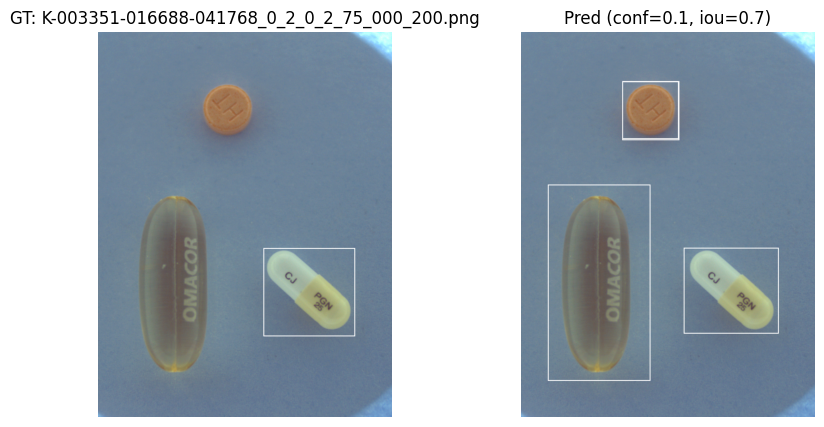

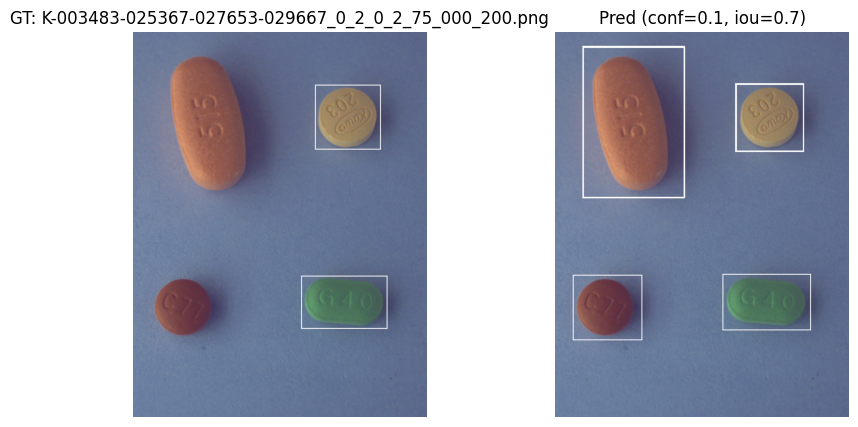

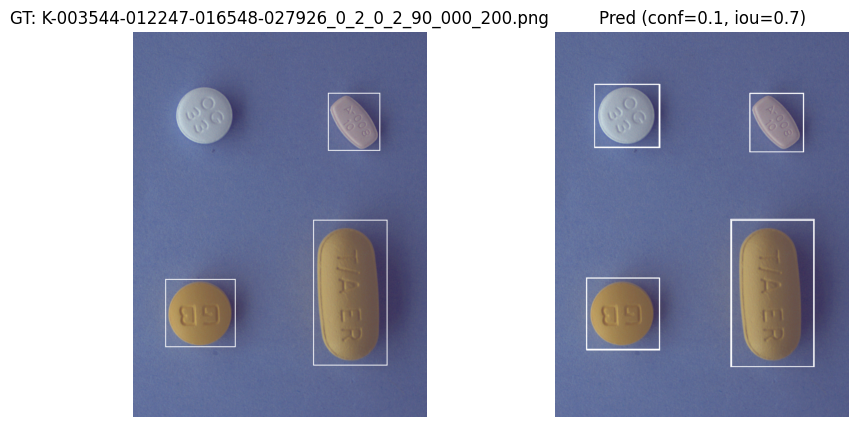

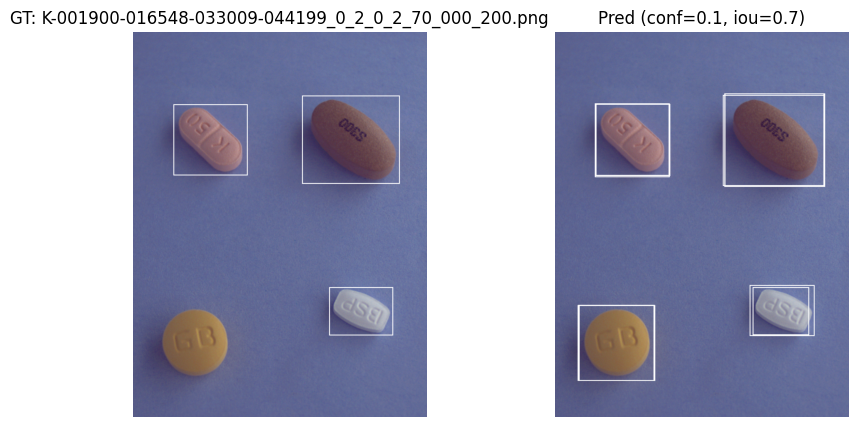

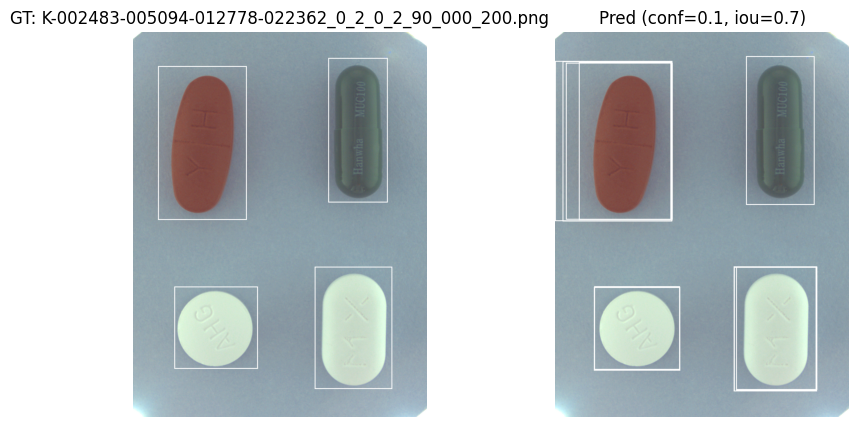

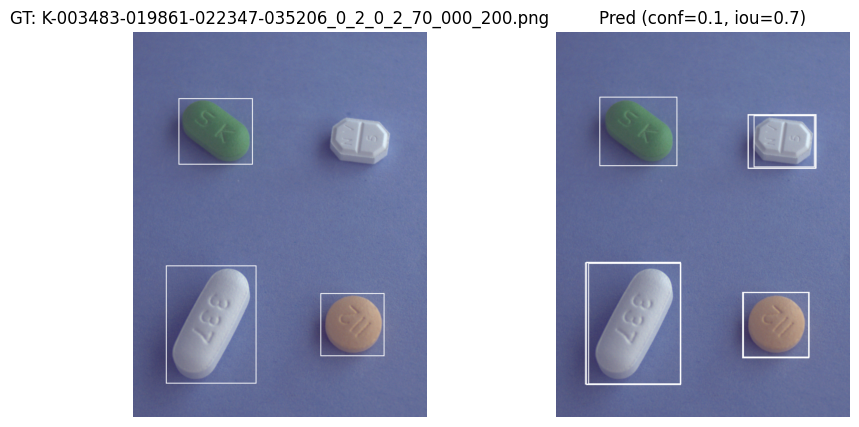

In [ ]:
import random, os
from PIL import Image, ImageDraw
import numpy as np
from pathlib import Path

from ultralytics import YOLO

WORKDIR = "/content/ev_pill_yolo"
DATA_YAML = f"{WORKDIR}/data.yaml"
MODEL_PATH = f"{RUN_DIR}/weights/best.pt"  # 혹은 'yolo11s.pt' (학습 중이면 현재 모델)

model = YOLO(MODEL_PATH)

# val 이미지 폴더
VAL_IMG_DIR = f"/content/ev_pill_yolo/_yolo_dataset/images/val"
VAL_LBL_DIR = f"/content/ev_pill_yolo/_yolo_dataset/labels/val"

val_imgs = sorted([str(p) for p in Path(VAL_IMG_DIR).glob("*.png")])
print("val images:", len(val_imgs))

# 시각화할 샘플 수
SAMPLES = 6
sample_imgs = random.sample(val_imgs, min(SAMPLES, len(val_imgs)))

# 예측 파라미터 (고정밀 추론 추천값)
IMGSZ = 1280
CONF  = 0.10
IOU   = 0.70

preds = model.predict(source=sample_imgs, imgsz=IMGSZ, conf=CONF, iou=IOU, max_det=20, augment=True, verbose=False)

def draw_yolo_labels_on(img_path, txt_path, color=None):
    im = Image.open(img_path).convert("RGB")
    W, H = im.size
    draw = ImageDraw.Draw(im)
    if Path(txt_path).exists():
        with open(txt_path, "r") as f:
            for line in f.read().strip().splitlines():
                if not line.strip():
                    continue
                cls, cx, cy, w, h = map(float, line.split())
                x = (cx - w/2) * W
                y = (cy - h/2) * H
                ww = w * W
                hh = h * H
                draw.rectangle([x, y, x+ww, y+hh], outline=color, width=3)
    return im

# 각 샘플에 대해 GT(왼쪽) / Pred(오른쪽) 비교
import matplotlib.pyplot as plt
for img_path, pred in zip(sample_imgs, preds):
    base = Path(img_path).stem
    gt_path = f"{VAL_LBL_DIR}/{base}.txt"

    # GT
    im_gt = draw_yolo_labels_on(img_path, gt_path, color=None)  # (색 지정 금지 규칙 준수)

    # Pred
    im_pred = Image.open(img_path).convert("RGB")
    W, H = im_pred.size
    draw = ImageDraw.Draw(im_pred)
    for b in pred.boxes.xyxy.cpu().numpy() if pred.boxes is not None else []:
        x1, y1, x2, y2 = b[:4]
        draw.rectangle([x1, y1, x2, y2], outline=None, width=3)  # 색 지정 X

    # 표시
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1); plt.imshow(im_gt);   plt.title(f"GT: {Path(img_path).name}"); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(im_pred); plt.title(f"Pred (conf={CONF}, iou={IOU})"); plt.axis("off")
    plt.show()


### mAP@[0.75:0.95] 정확 계산 (COCOeval)

Ultralytics의 기본 mAP50-95 외에 0.75~0.95 구간만 평균한 값을 COCO API로 직접 산출합니다.

개요

우리의 val split에 해당하는 GT COCO json 생성 (원본 COCO에서 val 이미지만 필터링)

model.val(save_json=True)로 예측 JSON(유사 COCO 포맷) 생성

pycocotools COCOeval로 IoU 0.75~0.95 평균 AP 계산

In [ ]:
# ============================================
# ✅ best.pt 자동탐색 → RUN_DIR 설정 → OOM-safe 검증
# ============================================
import os, gc, glob, json, numpy as np
from pathlib import Path
from ultralytics import YOLO

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# ---- 공통 경로 ----
WORKDIR       = "/content/ev_pill_yolo"
VAL_IMG_DIR   = f"{WORKDIR}/_yolo_dataset/images/val"
MAP_DIR       = f"{WORKDIR}/_maps"
OUT_DIR       = f"{WORKDIR}/_val_coco"
GT_VAL_JSON   = f"{OUT_DIR}/gt_val.json"
PRED_JSON     = f"{OUT_DIR}/pred_val_mapped.json"
ANN_ROOT      = "/content/drive/MyDrive/Codeit_AI_4th_Drug_image_CV_project/data/train_annotations"
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

# ---- 0) 가중치 자동탐색 (best.pt 우선, 없으면 last.pt) ----
SEARCH_ROOTS = ["/content/ev_pill_yolo", "/content/ev_pill", "/content", "/content/drive/MyDrive", "."]
ckpts = []
for root in SEARCH_ROOTS:
    ckpts += glob.glob(os.path.join(root, "**/weights/best.pt"), recursive=True)

if ckpts:
    BEST_PT = sorted(ckpts, key=lambda p: Path(p).stat().st_mtime, reverse=True)[0]
else:
    last_ckpts = []
    for root in SEARCH_ROOTS:
        last_ckpts += glob.glob(os.path.join(root, "**/weights/last.pt"), recursive=True)
    assert last_ckpts, "훈련 가중치(best.pt/last.pt)를 찾지 못했습니다. 학습 경로를 확인하세요."
    BEST_PT = sorted(last_ckpts, key=lambda p: Path(p).stat().st_mtime, reverse=True)[0]

RUN_DIR = Path(BEST_PT).parent.parent
print("✅ Using RUN_DIR:", RUN_DIR)
print("✅ Using CKPT   :", BEST_PT)


✅ Using RUN_DIR: /content/ev_pill/train_hp
✅ Using CKPT   : /content/ev_pill/train_hp/weights/best.pt


In [ ]:
yidx2catid_path = f"{MAP_DIR}/yidx2catid.json"
assert Path(yidx2catid_path).exists(), "yidx2catid.json이 없습니다. (COCO→YOLO 전처리 셀을 먼저 실행)"
yidx2catid = {int(k): int(v) for k, v in json.load(open(yidx2catid_path)).items()}

gt = json.load(open(GT_VAL_JSON, "r"))
fname2imgid = {Path(im["file_name"]).name.lower(): int(im["id"]) for im in gt["images"]}

# ---- 3) 스트리밍 예측 → COCO pred 리스트 (OOM-safe) ----
val_img_files = sorted([str(p) for p in Path(VAL_IMG_DIR).glob("*.png")])
assert val_img_files, "val 이미지가 비어 있습니다. 전처리 split을 확인하세요."

model = YOLO(BEST_PT)

def stream_predict_to_cocojson(
    img_files, imgsz=1024, batch=4, chunk_size=48, conf=0.10, iou=0.70, max_det=20, augment=False
):
    res = []
    done = 0
    for s in range(0, len(img_files), chunk_size):
        chunk = img_files[s:s+chunk_size]
        for r in model.predict(
            source=chunk, stream=True, imgsz=imgsz, batch=batch, workers=0, half=True, device=0,
            conf=conf, iou=iou, max_det=max_det, augment=augment, verbose=False, plots=False
        ):
            base = Path(r.path).name.lower()
            image_id = fname2imgid.get(base)
            if image_id is None or r.boxes is None or r.boxes.xyxy.numel()==0:
                done += 1; continue
            xyxy = r.boxes.xyxy.detach().cpu().numpy()
            clss = r.boxes.cls.detach().cpu().numpy().astype(int)
            confs= r.boxes.conf.detach().cpu().numpy()
            for (x1,y1,x2,y2), c_idx, sc in zip(xyxy, clss, confs):
                w = max(0.0, float(x2-x1)); h = max(0.0, float(y2-y1))
                res.append({"image_id": int(image_id),
                            "category_id": yidx2catid.get(int(c_idx), 0),
                            "bbox": [float(x1), float(y1), w, h],
                            "score": float(sc)})
            done += 1
        # 메모리 정리 + 중간 저장
        del chunk; gc.collect()
        try:
            import torch
            if torch.cuda.is_available(): torch.cuda.empty_cache()
        except: pass
        with open(PRED_JSON + ".part", "w") as f:
            json.dump(res, f)
        print(f"[progress] {done}/{len(img_files)}")
    return res

coco_results = stream_predict_to_cocojson(
    val_img_files, imgsz=1024, batch=4, chunk_size=48, conf=0.10, iou=0.70, max_det=20, augment=False
)
json.dump(coco_results, open(PRED_JSON, "w"))
print("✅ Saved predictions:", PRED_JSON, "| dets:", len(coco_results))

# ---- 4) COCOeval (0.75~0.95) ----
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np

cocoGt = COCO(GT_VAL_JSON)
cocoDt = cocoGt.loadRes(PRED_JSON)

ev = COCOeval(cocoGt, cocoDt, iouType="bbox")
ev.params.iouThrs = np.linspace(0.75, 0.95, 5)
ev.evaluate(); ev.accumulate(); ev.summarize()
print("🎯 mAP@[0.75:0.95] =", float(ev.stats[0]))

[progress] 48/223
[progress] 96/223
[progress] 144/223
[progress] 192/223
[progress] 223/223
✅ Saved predictions: /content/ev_pill_yolo/_val_coco/pred_val_mapped.json | dets: 1239
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.32s).
Accumulating evaluation results...
DONE (t=0.14s).
 Average Precision  (AP) @[ IoU=0.75:0.95 | area=   all | maxDets=100 ] = 0.065
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.083
 Average Precision  (AP) @[ IoU=0.75:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75:0.95 | area= large | maxDets=100 ] = 0.065
 Average Recall     (AR) @[ IoU=0.75:0.95 

mAP 0.065는 “모델이 못 배워서” 보다는 추론/후처리 설정이 현재 밸리데이션 지표(0.75~0.95)에 불리해서 생길 때가 많음

# 모델 검증

##Validation 실행 + 기본 플롯(PR/F1/P/R/CM) 보기

Using RUN_DIR: ev_pill/train_hp
Ultralytics 8.3.20 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 238 layers, 9,441,051 parameters, 0 gradients, 21.5 GFLOPs


val: Scanning /content/ev_pill_yolo/_yolo_dataset/labels/val.cache... 223 images, 0 backgrounds, 0 corrupt: 100%|██████████| 223/223 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/ev_pill_yolo/_yolo_dataset/images/val/K-001900-016548-018110-027926_0_2_0_2_70_000_200.png: 15 duplicate labels removed
val: WARNING ⚠️ /content/ev_pill_yolo/_yolo_dataset/images/val/K-001900-016548-018110-029451_0_2_0_2_70_000_200.png: 20 duplicate labels removed
val: WARNING ⚠️ /content/ev_pill_yolo/_yolo_dataset/images/val/K-001900-016548-019607-021026_0_2_0_2_70_000_200.png: 10 duplicate labels removed
val: WARNING ⚠️ /content/ev_pill_yolo/_yolo_dataset/images/val/K-001900-016548-019607-029345_0_2_0_2_70_000_200.png: 5 duplicate labels removed
val: WARNING ⚠️ /content/ev_pill_yolo/_yolo_dataset/images/val/K-001900-016548-019607-029451_0_2_0_2_75_000_200.png: 20 duplicate labels removed
val: WARNING ⚠️ /content/ev_pill_yolo/_yolo_dataset/images/val/K-001900-016548-019607-031705_0_2_0_2_70_000_200.png: 15 duplicate labels removed
val: WARNING ⚠️ /content/ev_pill_yolo/_yolo_dataset/images/val/K-001900-016548-021771-029345_0_2_0_2_75_000_200.png: 15 duplicate l


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:16<00:00,  2.27it/s]


                   all        223        679      0.401      0.682      0.552      0.494


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:432: UserWarning: Glyph 48372 (\N{HANGUL SYLLABLE BO}) missing from font(s) DejaVu Sans.
  fig.savefig(plot_fname, dpi=250)
/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:432: UserWarning: Glyph 47161 (\N{HANGUL SYLLABLE RYEONG}) missing from font(s) DejaVu Sans.
  fig.savefig(plot_fname, dpi=250)
/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:432: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from font(s) DejaVu Sans.
  fig.savefig(plot_fname, dpi=250)
/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:432: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  fig.savefig(plot_fname, dpi=250)
/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:432: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  fig.savefig(plot_fname, dpi=250)
/usr/local/lib/python3.12/dist

Speed: 0.4ms preprocess, 35.3ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/val
Val plots saved to: runs/detect/val


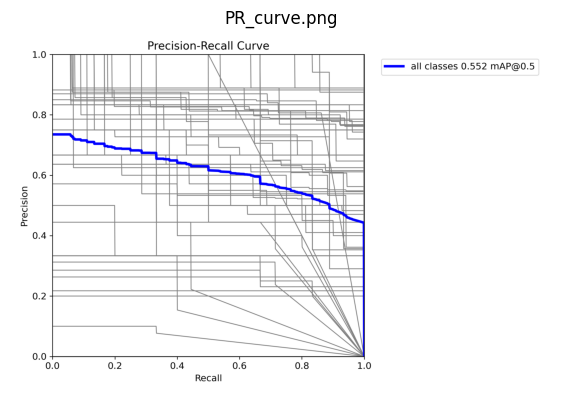

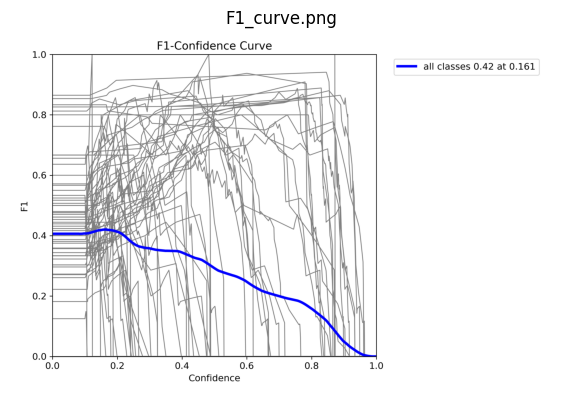

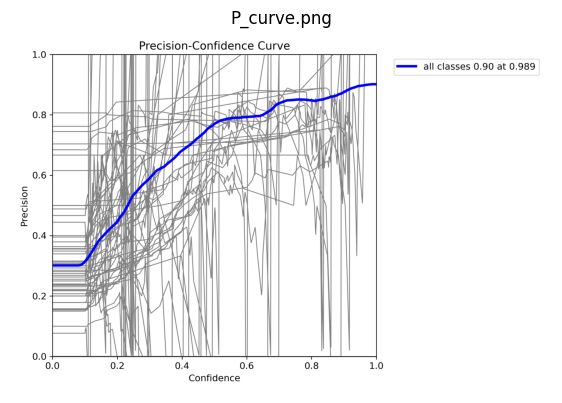

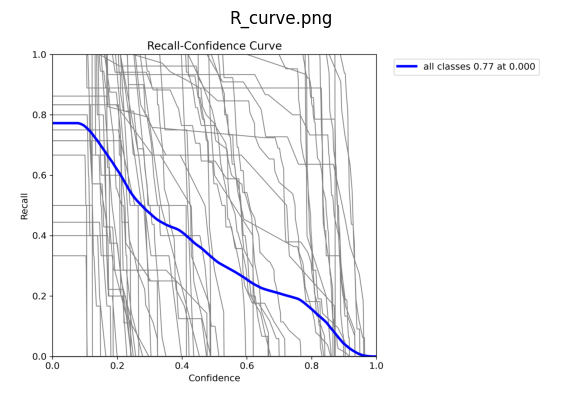

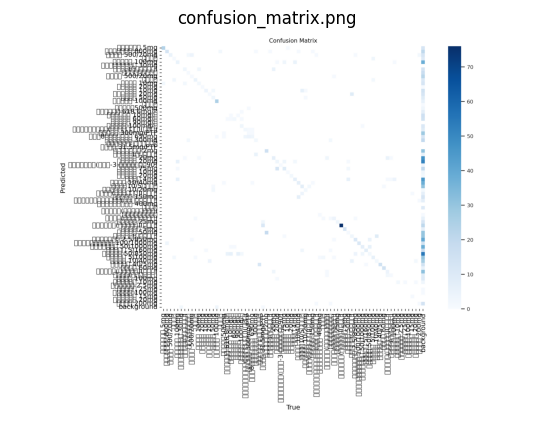

In [ ]:
# === 최신 run 자동 탐색 → best.pt로 검증 실행(플롯 생성) ===
import os, glob
from pathlib import Path
import matplotlib.pyplot as plt
from ultralytics import YOLO

WORKDIR   = "/content/ev_pill_yolo"
DATA_YAML = f"{WORKDIR}/data.yaml"
assert Path(DATA_YAML).exists(), "data.yaml 이 없습니다. 전처리 셀로 생성해주세요."

# 최신 run 디렉토리 자동 탐색 (…/weights/best.pt)
cands = []
for root in [f"{WORKDIR}/runs", "/content/ev_pill", "/content", "ev_pill", "."]:
    cands += glob.glob(os.path.join(root, "**/weights/best.pt"), recursive=True)
assert cands, "이전 학습 결과(…/weights/best.pt)를 찾지 못했습니다."

BEST_PT = sorted(set(cands), key=lambda p: Path(p).stat().st_mtime, reverse=True)[0]
RUN_DIR = Path(BEST_PT).parent.parent
print("Using RUN_DIR:", RUN_DIR)

# 검증(저메모리)
model = YOLO(BEST_PT)
valres = model.val(
    data=DATA_YAML,
    imgsz=1024,      # 여유면 1152/1280, 빠듯하면 960
    batch=6,         # 여유 없으면 4
    workers=0,
    half=True,
    conf=0.10, iou=0.70, max_det=20,
    augment=False,
    plots=True,      # PR/F1/P/R/CM 저장
    verbose=False
)
VAL_DIR = Path(valres.save_dir)
print("Val plots saved to:", VAL_DIR)

# 플롯 보여주기
for name in ["PR_curve.png","F1_curve.png","P_curve.png","R_curve.png","confusion_matrix.png"]:
    p = VAL_DIR / name
    if p.exists():
        img = plt.imread(str(p))
        plt.figure(figsize=(7,5))
        plt.imshow(img); plt.title(p.name); plt.axis("off"); plt.show()
    else:
        print("not found:", p)


##mAP 곡선( IoU별 AP ) 시각화

mAP@[0.75:0.95] = 0.064511966863657


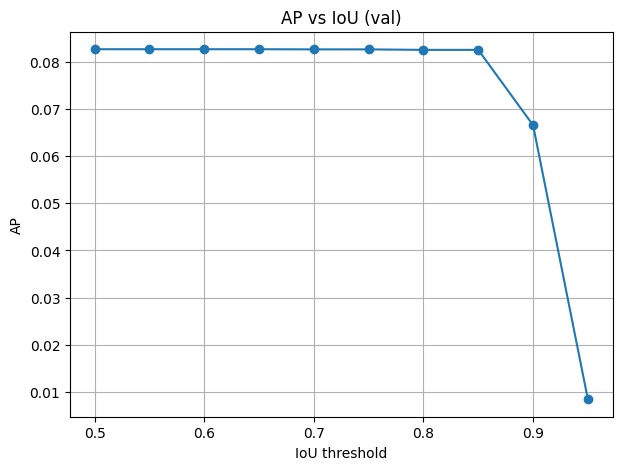

In [ ]:
# COCOeval 완료 후 (ev.evaluate(); ev.accumulate(); 가 끝난 뒤)

import numpy as np
import matplotlib.pyplot as plt

P = ev.eval["precision"]  # expected shape [T, R, K, A, M]

# area='all'(0), maxDet의 마지막 인덱스(-1: 보통 100) 선택해서 [T, R, K]로 축소
if P.ndim == 5:
    P = P[:, :, :, 0, -1]     # -> [T, R, K]
elif P.ndim == 4:
    P = P[:, :, :, 0]         # 드물게 M축이 없을 때 대비

# COCO는 매칭이 없으면 -1을 채웁니다 → NaN으로 바꿔 평균에서 제외
P = np.where(P < 0, np.nan, P)

# recall(R)과 class(K) 축을 평균 → T 길이의 IoU별 AP
AP_iou = np.nanmean(P, axis=(1, 2))  # shape: [T]

iou_thrs = ev.params.iouThrs
mask = (iou_thrs >= 0.75) & (iou_thrs <= 0.95)
map_075_095 = float(np.nanmean(AP_iou[mask]))
print("mAP@[0.75:0.95] =", map_075_095)

# IoU–AP 곡선 시각화
plt.figure(figsize=(7,5))
plt.plot(iou_thrs, AP_iou, marker="o")
plt.xlabel("IoU threshold")
plt.ylabel("AP")
plt.title("AP vs IoU (val)")
plt.grid(True)
plt.show()


# TTA 포함 conf × NMS IoU 최적화 → 테스트 CSV 생성
(1) pycocotools 임포트 확인/설치

(2) 가중치 자동탐색(best → last)

(3) GT 생성/검증 셋 로드

(4) TTA 포함 conf × NMS IoU 스윕으로 mAP@[0.75:0.95] 최대화

(5) 최적값으로 테스트 CSV 생성(Top-4, 최소크기 필터)

In [ ]:
# ============================================================
# OOM-자동회피 테스트 CSV 생성 (TTA 우선, 실패 시 단계적 다운그레이드)
# ============================================================
import os, gc, re, glob, json
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import torch
from ultralytics import YOLO

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "disabled"

# ---- 경로/설정 ----
WORKDIR    = "/content/ev_pill_yolo"
TEST_DIR   = "/content/drive/MyDrive/Codeit_AI_4th_Drug_image_CV_project/data/test_images"
MAP_DIR    = f"{WORKDIR}/_maps"
SUBMITDIR  = f"{WORKDIR}/_submit"
SEL_JSON   = f"{SUBMITDIR}/selected_conf_tta.json"   # 앞 단계에서 저장된 최적 conf/nms
Path(SUBMITDIR).mkdir(parents=True, exist_ok=True)

# 가중치 자동탐색
def find_ckpt():
    roots = ["/content/ev_pill_yolo","/content/ev_pill","/content","/content/drive/MyDrive","."]
    best, last = [], []
    for r in roots: best += glob.glob(os.path.join(r, "**/weights/best.pt"), recursive=True)
    if best: return sorted(best, key=lambda p: Path(p).stat().st_mtime, reverse=True)[0]
    for r in roots: last += glob.glob(os.path.join(r, "**/weights/last.pt"), recursive=True)
    assert last, "학습 가중치(.pt) 없음"
    return sorted(last, key=lambda p: Path(p).stat().st_mtime, reverse=True)[0]

CKPT = find_ckpt()
print("✅ Using ckpt:", CKPT)

# 매핑/파라미터 로드
yidx2catid = {int(k): int(v) for k,v in json.load(open(f"{MAP_DIR}/yidx2catid.json")).items()}
if Path(SEL_JSON).exists():
    sel = json.load(open(SEL_JSON))
    BEST_CONF = float(sel.get("best_conf_tta", 0.30))
    NMS_IOU   = float(sel.get("nms_iou", 0.60))
    IMGSZ0    = int(sel.get("imgsz", 1024))
else:
    BEST_CONF, NMS_IOU, IMGSZ0 = 0.30, 0.60, 1024
    print("⚠️ selected_conf_tta.json 없음 → 기본값 사용")

# 유틸
def extract_numeric_id(stem: str) -> int:
    nums = re.findall(r"\d+", stem)
    return int("".join(nums)) if nums else 0

def keep_box(x1,y1,x2,y2, W,H, min_ratio=0.0025):
    w = max(0.0, x2-x1); h = max(0.0, y2-y1)
    return (w*h) >= (W*H*min_ratio)

def empty_cuda():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# 후보 설정 (상단일수록 우선 시도)
CAND_CONFIGS = [
    # TTA ON (메모리 큼)
    dict(augment=True,  imgsz=IMGSZ0, batch=1),
    dict(augment=True,  imgsz=max(960, min(1152, IMGSZ0)), batch=1),
    # TTA OFF (메모리 훨씬 적음)
    dict(augment=False, imgsz=IMGSZ0, batch=2),
    dict(augment=False, imgsz=max(960, min(1152, IMGSZ0)), batch=2),
    dict(augment=False, imgsz=896, batch=1),
    dict(augment=False, imgsz=832, batch=1),
    dict(augment=False, imgsz=768, batch=1),
    # 최후 수단: CPU
    dict(augment=False, imgsz=640, batch=1, device="cpu"),
]

# 테스트 파일
test_imgs = sorted([str(p) for p in Path(TEST_DIR).glob("*.png")])
assert test_imgs, f"테스트 이미지 없음: {TEST_DIR}"

model = YOLO(CKPT)

rows, ann_id = [], 1
CHUNK = 32  # 파일 리스트를 청크로 나눠 처리 (OOM 위험 완화)

def run_one_chunk(chunk, cfg):
    """cfg로 chunk를 예측 → CSV rows append. 성공 시 True."""
    global rows, ann_id
    device = cfg.get("device", 0)
    try:
        for r in model.predict(
            source=chunk, stream=True,
            imgsz=cfg["imgsz"], batch=cfg["batch"], workers=0, half=(device!= "cpu"),
            device=device, conf=BEST_CONF, iou=NMS_IOU, max_det=20,
            augment=cfg["augment"], verbose=False, plots=False
        ):
            p = Path(r.path); stem = p.stem
            image_id = extract_numeric_id(stem)
            # 원본 크기
            if r.orig_shape is not None:
                H, W = r.orig_shape[:2]
            else:
                with Image.open(p) as im:
                    W, H = im.size

            if (r.boxes is None) or (r.boxes.xyxy.numel()==0):
                continue

            xyxy = r.boxes.xyxy.detach().cpu().numpy()
            clss = r.boxes.cls.detach().cpu().numpy().astype(int)
            confs= r.boxes.conf.detach().cpu().numpy()

            kept=[]
            for (x1,y1,x2,y2), c_idx, sc in zip(xyxy, clss, confs):
                if keep_box(float(x1),float(y1),float(x2),float(y2), W,H, min_ratio=0.0025):
                    kept.append((float(sc), int(c_idx), float(x1), float(y1), float(x2), float(y2)))
            kept.sort(reverse=True)
            kept = kept[:4]  # Top-4

            for sc, c_idx, x1, y1, x2, y2 in kept:
                w, h   = x2-x1, y2-y1
                bx, by = int(round(x1)), int(round(y1))
                bw, bh = int(round(w)),  int(round(h))
                cat_id = yidx2catid.get(int(c_idx), 0)
                rows.append([ann_id, image_id, cat_id, bx, by, bw, bh, float(sc)])
                ann_id += 1
        return True
    except RuntimeError as e:
        if "out of memory" in str(e).lower():
            print(f"⚠️ OOM @ cfg={cfg} → fallback 시도")
            empty_cuda()
            return False
        else:
            raise
    except torch.cuda.OutOfMemoryError:
        print(f"⚠️ OOM @ cfg={cfg} → fallback 시도")
        empty_cuda()
        return False

# 청크 루프: 각 청크를 가장 공격적인 설정부터 시도, 안되면 점점 보수적으로
total = len(test_imgs)
for s in range(0, total, CHUNK):
    chunk = test_imgs[s:s+CHUNK]
    success = False
    for cfg in CAND_CONFIGS:
        if run_one_chunk(chunk, cfg):
            print(f"[test pred] {min(s+len(chunk), total)}/{total} ✅ cfg={cfg}")
            success = True
            break
    if not success:
        raise RuntimeError("모든 설정에서 OOM 발생 — chunk 크기를 더 줄이거나(예: 16), 이미지 크기를 더 낮추세요.")

# 저장
cols = ["annotation_id","image_id","category_id","bbox_x","bbox_y","bbox_w","bbox_h","score"]
df = pd.DataFrame(rows, columns=cols)
csv_path = f"{SUBMITDIR}/submission_auto_oom_conf{BEST_CONF:.2f}_nms{NMS_IOU:.2f}_top4.csv"
df.to_csv(csv_path, index=False)
print("===================================================")
print("✅ submission saved:", csv_path)
print("rows:", len(df))
print(df.head(10).to_string(index=False))
print("===================================================")


✅ Using ckpt: /content/ev_pill/train_hp/weights/best.pt
[test pred] 32/526 ✅ cfg={'augment': True, 'imgsz': 1024, 'batch': 1}
[test pred] 64/526 ✅ cfg={'augment': True, 'imgsz': 1024, 'batch': 1}
[test pred] 96/526 ✅ cfg={'augment': True, 'imgsz': 1024, 'batch': 1}
[test pred] 128/526 ✅ cfg={'augment': True, 'imgsz': 1024, 'batch': 1}
[test pred] 160/526 ✅ cfg={'augment': True, 'imgsz': 1024, 'batch': 1}
[test pred] 192/526 ✅ cfg={'augment': True, 'imgsz': 1024, 'batch': 1}
[test pred] 224/526 ✅ cfg={'augment': True, 'imgsz': 1024, 'batch': 1}
[test pred] 256/526 ✅ cfg={'augment': True, 'imgsz': 1024, 'batch': 1}
[test pred] 288/526 ✅ cfg={'augment': True, 'imgsz': 1024, 'batch': 1}
[test pred] 320/526 ✅ cfg={'augment': True, 'imgsz': 1024, 'batch': 1}
[test pred] 352/526 ✅ cfg={'augment': True, 'imgsz': 1024, 'batch': 1}
[test pred] 384/526 ✅ cfg={'augment': True, 'imgsz': 1024, 'batch': 1}
[test pred] 416/526 ✅ cfg={'augment': True, 'imgsz': 1024, 'batch': 1}
[test pred] 448/526 ✅ cf

# 이미지 정리 + 추론

✅ Using ckpt: /content/ev_pill/train_hp/weights/best.pt
saved: /content/ev_pill_yolo/_viz/val/K-001900-016551-021026-033208_0_2_0_2_90_000_200_viz.png
saved: /content/ev_pill_yolo/_viz/val/K-003351-018147-038162_0_2_0_2_90_000_200_viz.png
saved: /content/ev_pill_yolo/_viz/val/K-003483-027777-028763-035206_0_2_0_2_75_000_200_viz.png
saved: /content/ev_pill_yolo/_viz/val/K-003483-020238-022347-027653_0_2_0_2_75_000_200_viz.png
saved: /content/ev_pill_yolo/_viz/val/K-001900-016548-027926-033208_0_2_0_2_70_000_200_viz.png
saved: /content/ev_pill_yolo/_viz/val/K-001900-016548-029345-033208_0_2_0_2_75_000_200_viz.png
saved: /content/ev_pill_yolo/_viz/val/K-003351-003832-036637_0_2_0_2_90_000_200_viz.png
saved: /content/ev_pill_yolo/_viz/val/K-002483-005094-005886-023223_0_2_0_2_70_000_200_viz.png


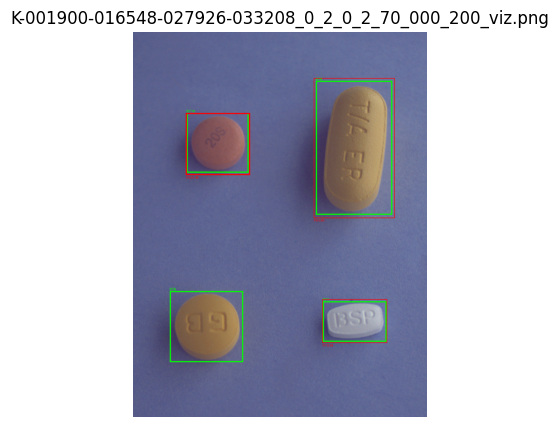

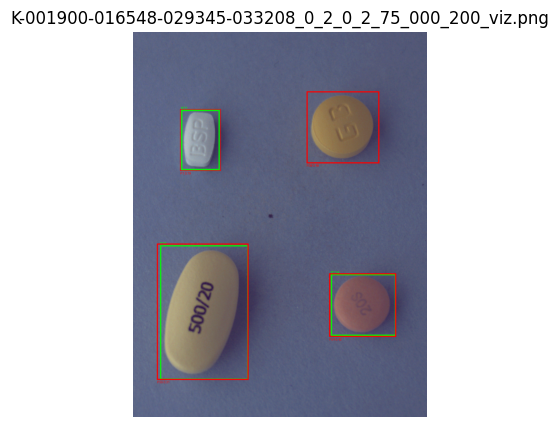

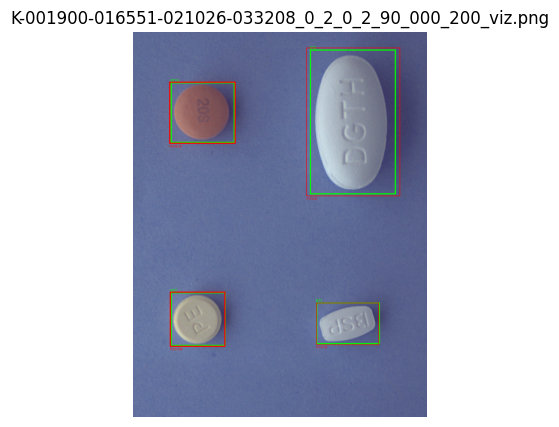

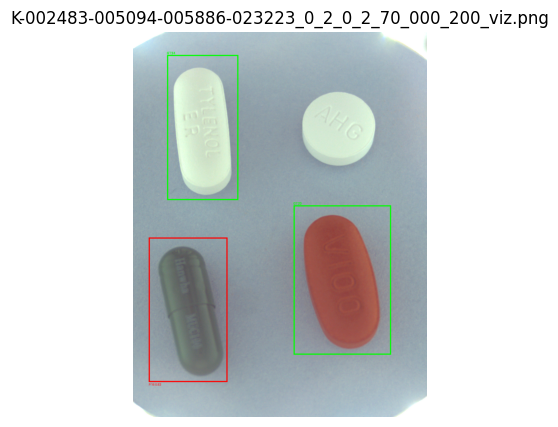

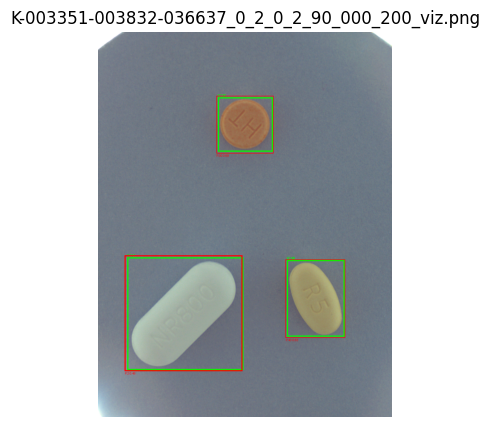

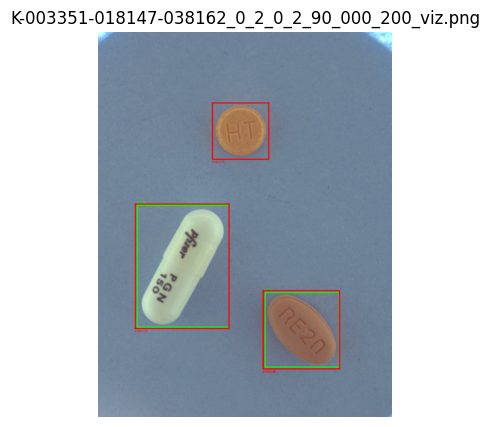

✅ val 시각화 8장 완료 → /content/ev_pill_yolo/_viz/val


In [ ]:
# ============================================================
# 이미지 시각화 (VAL: GT vs Pred, TEST: Pred만) — OOM-safe
# ============================================================
import os, gc, glob, json, random
from pathlib import Path
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from ultralytics import YOLO

# ---- 공통 경로/옵션 ----
WORKDIR       = "/content/ev_pill_yolo"
VAL_IMG_DIR   = f"{WORKDIR}/_yolo_dataset/images/val"
TEST_IMG_DIR  = "/content/drive/MyDrive/Codeit_AI_4th_Drug_image_CV_project/data/test_images"
MAP_DIR       = f"{WORKDIR}/_maps"
OUT_VIZ_DIR   = f"{WORKDIR}/_viz"
VAL_COCO_JSON = f"{WORKDIR}/_val_coco/gt_val.json"   # 이전 단계에서 만든 GT
PRED_CACHE    = f"{WORKDIR}/_val_coco/pred_val_mapped.json"  # 있으면 재사용

# 시각화 설정
MODE         = "val"      # "val" 또는 "test"
N_SAMPLES    = 8          # 그릴 이미지 수
SAMPLE_MODE  = "random"   # "random" | "first"
CONF         = 0.30       # 추론 conf
NMS_IOU      = 0.60       # NMS IoU
IMGSZ        = 1024       # 추론 해상도 (VRAM 맞춰 조절)
BATCH        = 2          # VRAM 맞춰 조절
CHUNK        = 24         # 파일 리스트 청크 크기
TOPK         = 4          # 이미지당 최대 박스 수
MIN_RATIO    = 0.0025     # 최소 박스 면적 비율(초소형 FP 컷)

Path(OUT_VIZ_DIR).mkdir(parents=True, exist_ok=True)

# ---- 유틸/헬퍼 ----
def find_ckpt():
    roots = ["/content/ev_pill_yolo","/content/ev_pill","/content","/content/drive/MyDrive","."]
    best = []
    for r in roots: best += glob.glob(os.path.join(r, "**/weights/best.pt"), recursive=True)
    if best: return sorted(best, key=lambda p: Path(p).stat().st_mtime, reverse=True)[0]
    last = []
    for r in roots: last += glob.glob(os.path.join(r, "**/weights/last.pt"), recursive=True)
    assert last, "학습 가중치(.pt)를 찾지 못했습니다."
    return sorted(last, key=lambda p: Path(p).stat().st_mtime, reverse=True)[0]

def keep_box(x1,y1,x2,y2, W,H, min_ratio=MIN_RATIO):
    w = max(0.0, x2-x1); h = max(0.0, y2-y1)
    return (w*h) >= (W*H*min_ratio)

def iou_xywh(b1, b2):
    x1,y1,w1,h1 = b1; x2,y2,w2,h2 = b2
    xa1, ya1, xa2, ya2 = x1, y1, x1+w1, y1+h1
    xb1, yb1, xb2, yb2 = x2, y2, x2+w2, y2+h2
    inter = max(0, min(xa2, xb2) - max(xa1, xb1)) * max(0, min(ya2, yb2) - max(ya1, yb1))
    ua = w1*h1 + w2*h2 - inter
    return inter/ua if ua>0 else 0.0

def greedy_match(gt_list, pr_list, thr=0.75):
    # gt_list: [(cat, [x,y,w,h]), ...]
    # pr_list: [(cat, [x,y,w,h], score), ...]
    used_gt=set(); used_pr=set()
    order = sorted(range(len(pr_list)), key=lambda i: pr_list[i][2], reverse=True)
    for i in order:
        pc, pb, ps = pr_list[i]
        best_j, best_iou = -1, 0.0
        for j,(gc, gb) in enumerate(gt_list):
            if j in used_gt or gc!=pc: continue
            iou = iou_xywh(pb, gb)
            if iou>=thr and iou>best_iou:
                best_j, best_iou = j, iou
        if best_j>=0:
            used_pr.add(i); used_gt.add(best_j)
    return used_pr, used_gt

def draw_overlay(img_path, preds, gts=None, match_thr=0.75):
    """
    preds: [(cat_id, [x1,y1,x2,y2], score)]
    gts  : [(cat_id, [x,y,w,h])]
    """
    im = Image.open(img_path).convert("RGB")
    W,H = im.size
    dr = ImageDraw.Draw(im)

    used_pr=set(); used_gt=set()
    if gts is not None:
        # GT는 xywh, Pred는 xyxy → match 위해 변환
        pr_list = [(c,[x1,y1,x2-x1,y2-y1],s) for (c,(x1,y1,x2,y2),s) in preds]
        used_pr, used_gt = greedy_match(gts, pr_list, thr=match_thr)

    # GT 박스(초록) — 매칭 실패는 두껍게
    if gts is not None:
        for j,(gc,gb) in enumerate(gts):
            x,y,w,h = gb
            x2,y2 = x+w, y+h
            width = 4 if j not in used_gt else 2
            dr.rectangle([x,y,x2,y2], outline=(0,255,0), width=width)
            dr.text((x, max(0,y-12)), f"GT:{gc}", fill=(0,255,0))

    # Pred 박스(빨강) — FP는 두껍게
    for i,(pc,(x1,y1,x2,y2),ps) in enumerate(preds):
        width = 4 if (gts is not None and i not in used_pr) else 2
        dr.rectangle([x1,y1,x2,y2], outline=(255,0,0), width=width)
        dr.text((x1, min(H-12,y2+2)), f"P:{pc} {ps:.2f}", fill=(255,0,0))

    return im

# ---- 모델/매핑 로드 ----
CKPT = find_ckpt()
print("✅ Using ckpt:", CKPT)
model = YOLO(CKPT)

y2c_path = f"{MAP_DIR}/yidx2catid.json"
assert Path(y2c_path).exists(), f"missing: {y2c_path}"
yidx2catid = {int(k): int(v) for k,v in json.load(open(y2c_path)).items()}

# ---- 대상 이미지 선택 ----
if MODE == "val":
    assert Path(VAL_COCO_JSON).exists(), "val GT JSON이 없습니다. 앞 단계에서 생성하세요."
    gt_full = json.load(open(VAL_COCO_JSON, "r"))
    fname2imgid = {Path(im["file_name"]).name.lower(): int(im["id"]) for im in gt_full["images"]}
    imgid2gts = {}
    for a in gt_full["annotations"]:
        imgid2gts.setdefault(int(a["image_id"]), []).append((int(a["category_id"]), a["bbox"]))  # xywh

    val_imgs = sorted([str(p) for p in Path(VAL_IMG_DIR).glob("*.png")])
    if SAMPLE_MODE=="random":
        samples = random.sample(val_imgs, min(N_SAMPLES, len(val_imgs)))
    else:
        samples = val_imgs[:N_SAMPLES]

elif MODE == "test":
    test_imgs = sorted([str(p) for p in Path(TEST_IMG_DIR).glob("*.png")])
    assert test_imgs, "테스트 이미지가 없습니다."
    if SAMPLE_MODE=="random":
        samples = random.sample(test_imgs, min(N_SAMPLES, len(test_imgs)))
    else:
        samples = test_imgs[:N_SAMPLES]
else:
    raise ValueError("MODE must be 'val' or 'test'")

# ---- 스트리밍 추론 → 각 이미지별 오버레이 만들기 ----
def xyxy_from_result(r):
    # numpy arrays
    xyxy = r.boxes.xyxy.detach().cpu().numpy() if (r.boxes is not None and r.boxes.xyxy.numel()>0) else np.zeros((0,4))
    clss = r.boxes.cls.detach().cpu().numpy().astype(int) if (r.boxes is not None and r.boxes.xyxy.numel()>0) else np.zeros((0,),dtype=int)
    conf = r.boxes.conf.detach().cpu().numpy() if (r.boxes is not None and r.boxes.xyxy.numel()>0) else np.zeros((0,))
    return xyxy, clss, conf

def build_preds(r, yidx2catid, W, H):
    xyxy, clss, conf = xyxy_from_result(r)
    items=[]
    for (x1,y1,x2,y2), c_idx, sc in zip(xyxy, clss, conf):
        if keep_box(float(x1),float(y1),float(x2),float(y2), W,H, MIN_RATIO):
            items.append(( yidx2catid.get(int(c_idx), 0), [float(x1),float(y1),float(x2),float(y2)], float(sc) ))
    # score 내림차순 → Top-K
    items.sort(key=lambda t: t[2], reverse=True)
    return items[:TOPK]

viz_dir = Path(OUT_VIZ_DIR) / MODE
viz_dir.mkdir(parents=True, exist_ok=True)

done=0
for r in model.predict(
    source=samples, stream=True,
    imgsz=IMGSZ, batch=BATCH, workers=0, half=True, device=0,
    conf=CONF, iou=NMS_IOU, max_det=20, augment=False,  # 필요시 True로 TTA
    verbose=False, plots=False
):
    p = Path(r.path)
    save_name = f"{p.stem}_viz.png"
    # 원본 크기
    if r.orig_shape is not None:
        H, W = r.orig_shape[:2]
    else:
        with Image.open(p) as im0: W,H = im0.size

    preds = build_preds(r, yidx2catid, W,H)

    if MODE == "val":
        iid = None
        # GT image_id 찾기 (basename 매칭)
        # val 경로의 파일명과 GT의 file_name basename이 동일하다고 가정
        iid = fname2imgid.get(p.name.lower())
        gts = imgid2gts.get(int(iid), []) if iid is not None else []
        canvas = draw_overlay(str(p), preds, gts, match_thr=0.75)
    else:
        canvas = draw_overlay(str(p), preds, gts=None)

    outp = viz_dir / save_name
    canvas.save(outp)
    print(f"saved: {outp}")
    done+=1

# ---- 미리보기 ----
pngs = sorted(glob.glob(str(viz_dir / "*.png")))
for pf in pngs[:min(6,len(pngs))]:
    img = plt.imread(pf)
    plt.figure(figsize=(7,5)); plt.imshow(img); plt.title(Path(pf).name); plt.axis("off"); plt.show()

print(f"✅ {MODE} 시각화 {done}장 완료 → {viz_dir}")
